In [1]:
import os
import shutil
import pandas as pd
from openpyxl import load_workbook

def extract_pdb_id_from_dockq(filename):
    """Extracts the PDB ID from a DockQ filename."""
    parts = filename.split('_')
    return parts[0]  # PDB ID is the first part

def extract_pdb_id_from_foldx(filename):
    """Extracts the PDB ID from a foldx filename."""
    parts = filename.split('_')
    return parts[2]  # PDB ID is after 'foldx_scoring'

def copy_foldx_sheets_to_dockq(dockq_dir, foldx_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    dockq_files = os.listdir(dockq_dir)
    foldx_files = os.listdir(foldx_dir)
    
    # Map foldx files to their PDB IDs
    foldx_map = {extract_pdb_id_from_foldx(f).upper(): f for f in foldx_files if 'binding_data' in f}
    
    for dockq_file in dockq_files:
        if dockq_file.endswith('_TB.xlsx') and 'DockQ_data' in dockq_file:
            pdb_id = extract_pdb_id_from_dockq(dockq_file).upper()
            if pdb_id in foldx_map:
                dockq_path = os.path.join(dockq_dir, dockq_file)
                foldx_path = os.path.join(foldx_dir, foldx_map[pdb_id])
                output_path = os.path.join(output_dir, dockq_file)
                
                # Copy the DockQ file to the output directory if it's not already there
                if not os.path.exists(output_path):
                    shutil.copyfile(dockq_path, output_path)
                
                print(f"Processing {dockq_file} and {foldx_map[pdb_id]} for PDB ID {pdb_id}")
                
                foldx_df = pd.read_excel(foldx_path, sheet_name='Sheet1')
                
                with pd.ExcelWriter(output_path, engine='openpyxl', mode='a') as writer:
                    book = load_workbook(output_path)
                    writer.book = book
                    if 'Foldx' in book.sheetnames:
                        std = book['Foldx']
                        book.remove(std)
                    foldx_df.to_excel(writer, sheet_name='Foldx', index=False)
                    
                    print(f'Updated {dockq_file} with Foldx data for PDB ID {pdb_id}')
            else:
                print(f"No matching Foldx file found for {dockq_file}")

# Replace these paths with the actual paths to your directories
dockq_dir = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Data_Evaluation/DockQ/DockQ_Evaluation/DockQ_Analysis/Data/AlphaFold_Multimer_All_TB'
foldx_dir = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/foldx_TB'
output_dir = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/foldx_TB_Dock'

copy_foldx_sheets_to_dockq(dockq_dir, foldx_dir, output_dir)



Processing 8C3H_DockQ_data_TB.xlsx and binding_data_8c3h_TB.xlsx for PDB ID 8C3H
Updated 8C3H_DockQ_data_TB.xlsx with Foldx data for PDB ID 8C3H
Processing 7QOX_DockQ_data_TB.xlsx and binding_data_7qox_TB.xlsx for PDB ID 7QOX
Updated 7QOX_DockQ_data_TB.xlsx with Foldx data for PDB ID 7QOX
Processing 8F8Z_DockQ_data_TB.xlsx and binding_data_8f8z_TB.xlsx for PDB ID 8F8Z
Updated 8F8Z_DockQ_data_TB.xlsx with Foldx data for PDB ID 8F8Z
Processing 8CK5_DockQ_data_TB.xlsx and binding_data_8ck5_TB.xlsx for PDB ID 8CK5
Updated 8CK5_DockQ_data_TB.xlsx with Foldx data for PDB ID 8CK5
Processing 8DGM_DockQ_data_TB.xlsx and binding_data_8dgm_TB.xlsx for PDB ID 8DGM
Updated 8DGM_DockQ_data_TB.xlsx with Foldx data for PDB ID 8DGM
Processing 7XV1_DockQ_data_TB.xlsx and binding_data_7xv1_TB.xlsx for PDB ID 7XV1
Updated 7XV1_DockQ_data_TB.xlsx with Foldx data for PDB ID 7XV1
Processing 8A68_DockQ_data_TB.xlsx and binding_data_8a68_TB.xlsx for PDB ID 8A68
Updated 8A68_DockQ_data_TB.xlsx with Foldx data f

In [2]:
import pandas as pd
import os
import re

# Define the directories
input_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/foldx_TB_Dock'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/alphafold_rank_Foldx_TB'

# Ensure the output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Function to extract the rank number
def extract_rank(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

# Process each Excel file in the directory
for filename in os.listdir(input_directory):
    if filename.endswith('.xlsx') or filename.endswith('.xls'):
        file_path = os.path.join(input_directory, filename)
        output_file_path = os.path.join(output_directory, filename)
        
        # Load the workbook
        xls = pd.ExcelFile(file_path)
        
        # Initialize a dict to hold dataframes
        dfs = {}
        for sheet_name in xls.sheet_names:
            # Read each sheet into a dataframe
            df = xls.parse(sheet_name)
            
            # Modify the "Foldx" sheet
            if sheet_name == 'Foldx':
                # Extract "alphafold rank" and reorder columns
                df['alphafold rank'] = df['Unnamed: 0'].apply(extract_rank)
                cols = ['alphafold rank'] + [col for col in df if col != 'alphafold rank']
                df = df[cols]

                # Delete rows where "Unnamed: 0" contains "native"
                # Adjust the column name if the information is located in a different column
                df = df[~df['Unnamed: 0'].str.contains("native", case=False, na=False)]
            
            # Store the modified (or unmodified) dataframe
            dfs[sheet_name] = df
        
        # Write all dataframes to a new Excel file
        with pd.ExcelWriter(output_file_path, engine='openpyxl') as writer:
            for sheet_name, df in dfs.items():
                df.to_excel(writer, sheet_name=sheet_name, index=False)

print("All files have been processed and saved to the output directory.")




All files have been processed and saved to the output directory.


In [3]:
import pandas as pd
import os
import re

def process_excel_files(input_directory, output_directory):
    # Ensure output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Iterate through all Excel files in the input directory
    for filename in os.listdir(input_directory):
        if filename.endswith('.xlsx'):
            file_path = os.path.join(input_directory, filename)
            output_file_path = os.path.join(output_directory, filename)
            
            # Load the Excel file
            xls = pd.ExcelFile(file_path)
            
            # Create a Pandas Excel writer using XlsxWriter as the engine.
            writer = pd.ExcelWriter(output_file_path, engine='xlsxwriter')
            
            # Process each sheet
            for sheet_name in xls.sheet_names:
                df = pd.read_excel(file_path, sheet_name=sheet_name)
                
                # Specific operations for the 'Foldx' sheet
                if sheet_name == 'Foldx':
                    # Extracting alphafold rank from 'Unnamed: 0' and adding it as a new column if not exists
                    if 'alphafold rank' not in df.columns:
                        df['alphafold rank'] = df['Unnamed: 0'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)
                    
                    # Delete rows related to 'native'
                    df = df[df['Unnamed: 0'].str.contains('native') == False]
                    
                    # Rank data based on Stability column
                    df = df.sort_values(by='Stability')
                    df['stability_rank'] = range(len(df))
                
                # Write each DataFrame to a specific sheet
                df.to_excel(writer, sheet_name=sheet_name, index=False)
            
            # Close the Pandas Excel writer and output the Excel file
            writer.save()

# Example usage
input_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/alphafold_rank_Foldx_TB'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/stability_TB'
process_excel_files(input_directory, output_directory)


In [4]:
import os
import pandas as pd
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

# Define the source and output directories
source_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/alphafold_rank_Foldx_TB'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/interaction_TB'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Iterate over all Excel files in the source directory
for filename in os.listdir(source_directory):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(source_directory, filename)
        
        # Load the workbook and sheet
        workbook = load_workbook(file_path)
        if 'Foldx' in workbook.sheetnames:
            ws = workbook['Foldx']
            data = ws.values
            columns = next(data)[0:]  # First row for column names
            df = pd.DataFrame(data, columns=columns)
            df = df[1:]  # Remove the header row from the data
            
            # Convert 'interaction_energy' to numeric and sort
            df['interaction_energy'] = pd.to_numeric(df['interaction_energy'], errors='coerce')
            df_sorted = df.sort_values(by='interaction_energy').reset_index(drop=True)
            df_sorted['interaction_energy_rank'] = range(len(df_sorted))
            
            # Clear existing data in the sheet
            for row in ws['A2:Z' + str(ws.max_row)]:
                for cell in row:
                    cell.value = None

            # Write the updated DataFrame back to the Excel sheet, including header
            for r_idx, row in enumerate(dataframe_to_rows(df_sorted, index=False, header=True), start=1):
                for c_idx, val in enumerate(row, start=1):
                    ws.cell(row=r_idx, column=c_idx, value=val)
            
            # Save the workbook to a new file in the output directory
            output_file_path = os.path.join(output_directory, filename)
            workbook.save(output_file_path)

print("Processing complete. All files have been updated.")


Processing complete. All files have been updated.


In [ ]:
import os
import openpyxl

# Set the directory containing the Excel files
directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/interaction_TB'

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.xlsx'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        # Load the workbook
        workbook = openpyxl.load_workbook(file_path)
        
        # Check if 'Foldx' sheet is in the workbook
        if 'Foldx' in workbook.sheetnames:
            # Rename the sheet
            workbook["Foldx"].title = "Foldx_Int"
            # Save the changes to the same file
            workbook.save(file_path)
            #print(f'Renamed sheet in {filename}')
        else:
            print(f'No sheet named "Foldx" in {filename}')

print("Sheet renaming complete.")


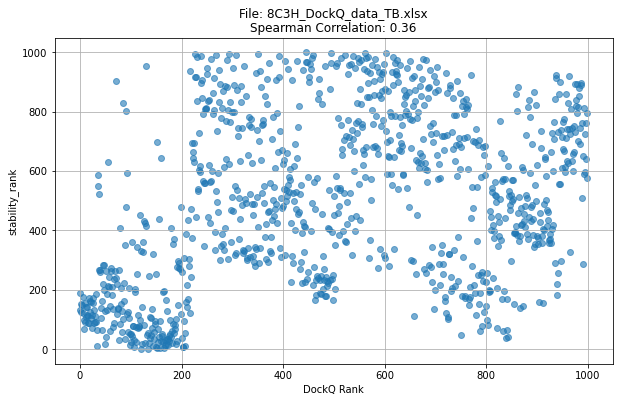

File: 8C3H_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.3614848694848695



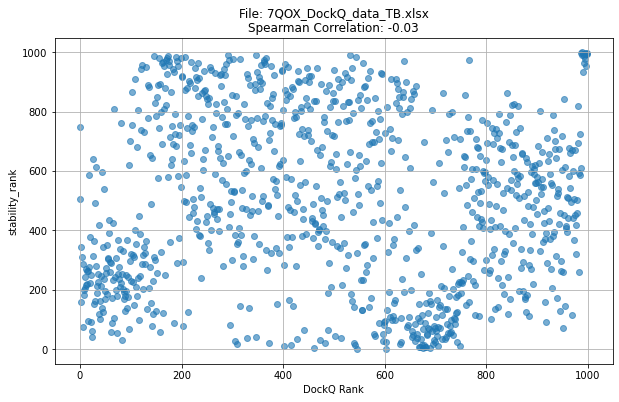

File: 7QOX_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.03282411282411282



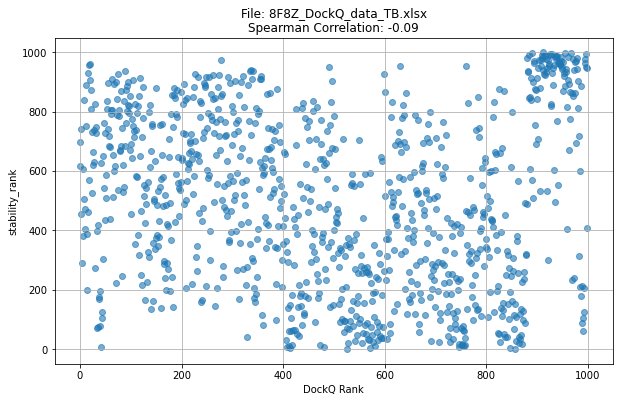

File: 8F8Z_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.08933788133788134



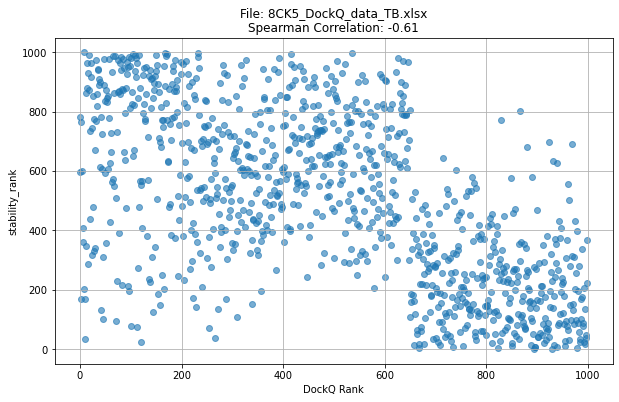

File: 8CK5_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.6112553872553873



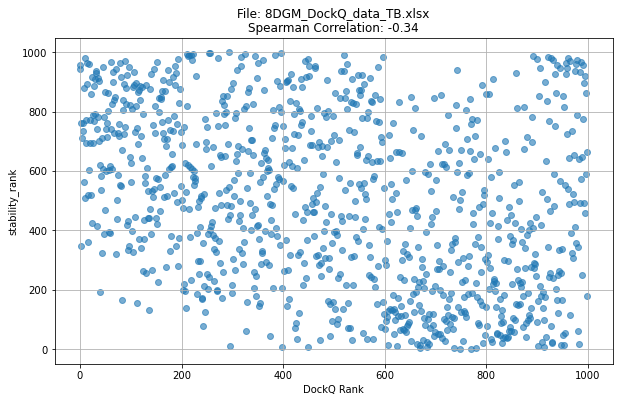

File: 8DGM_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.3406500646500647



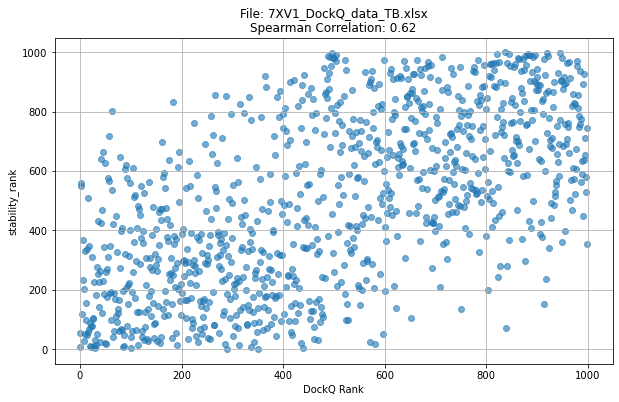

File: 7XV1_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.6248571248571249



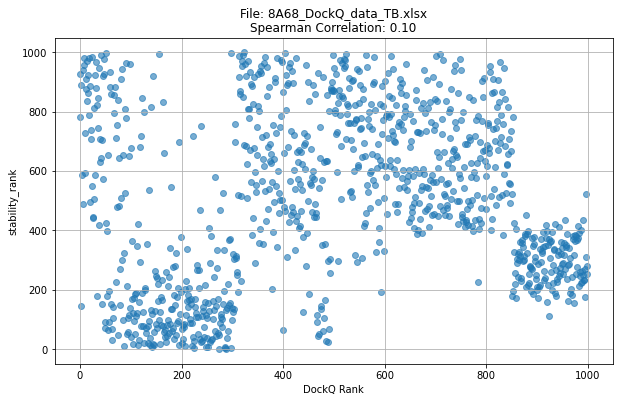

File: 8A68_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.09960819960819962



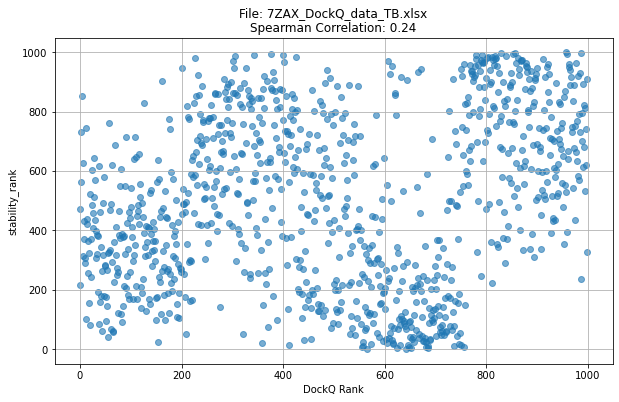

File: 7ZAX_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.23637656037656038



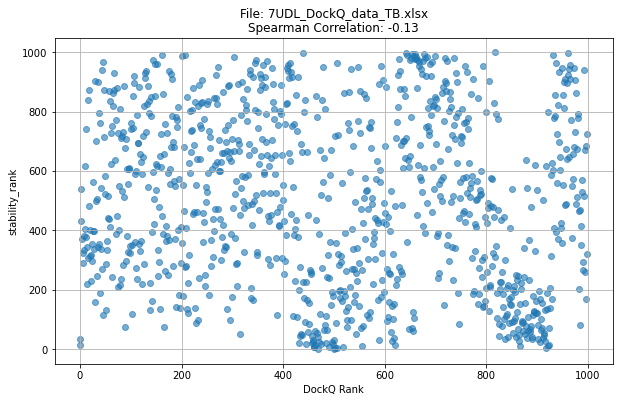

File: 7UDL_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.13245910845910847



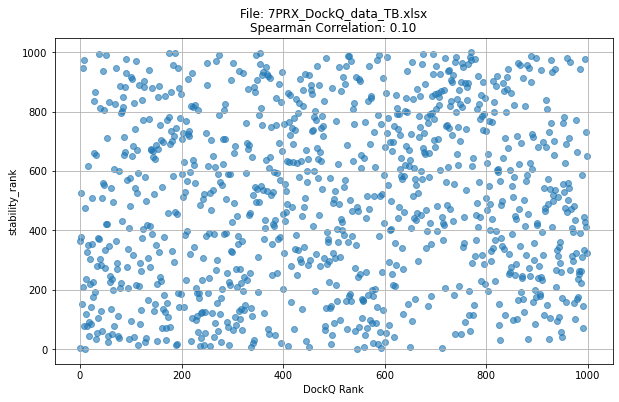

File: 7PRX_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.0954744714744715



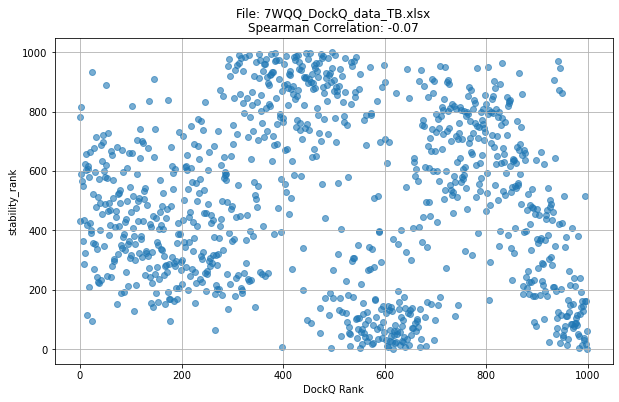

File: 7WQQ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.06893820893820894



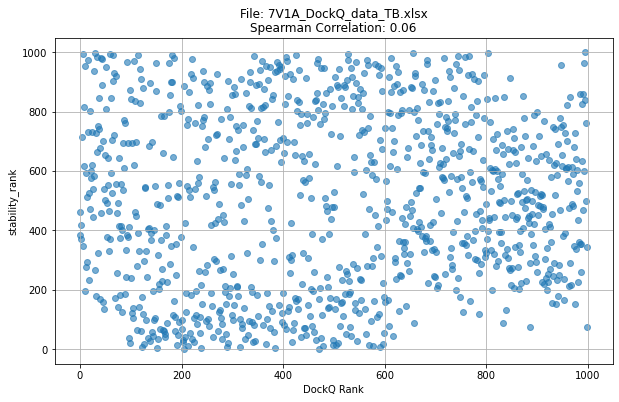

File: 7V1A_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.06300839100839101



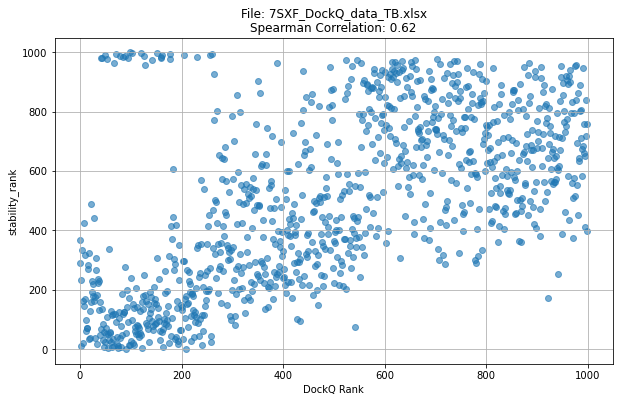

File: 7SXF_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.6219228339228339



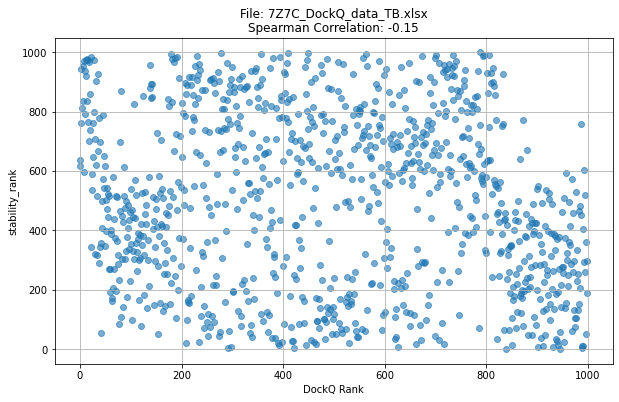

File: 7Z7C_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.15100237900237903



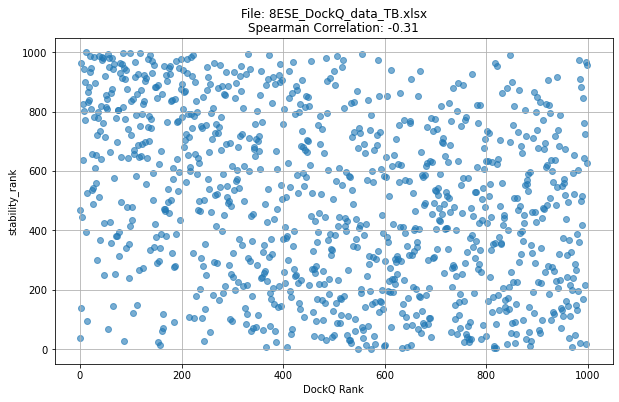

File: 8ESE_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.30734446334446336



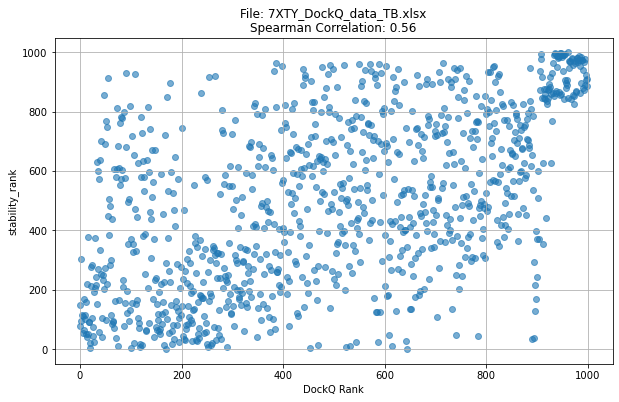

File: 7XTY_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.5603200763200763



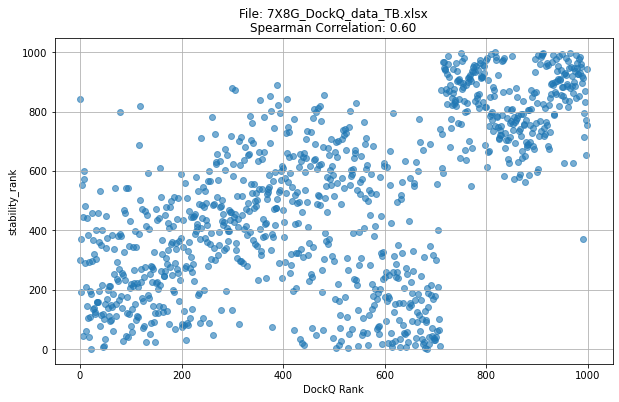

File: 7X8G_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.6016901776901777



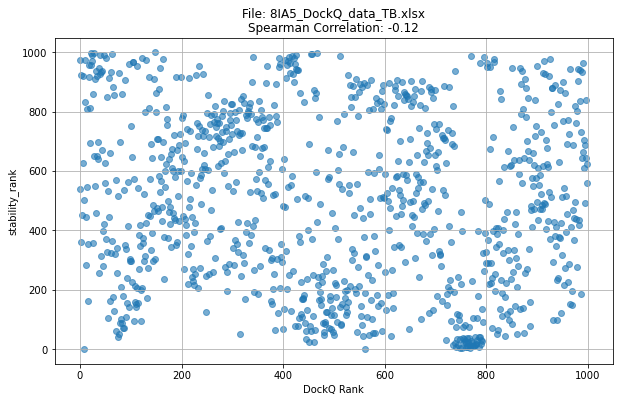

File: 8IA5_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.1161019881019881



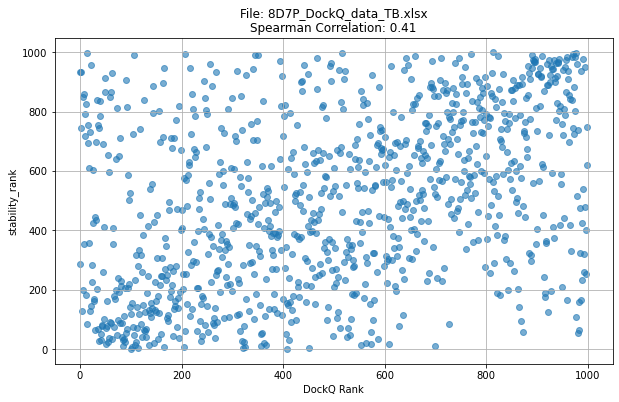

File: 8D7P_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.41187721587721593



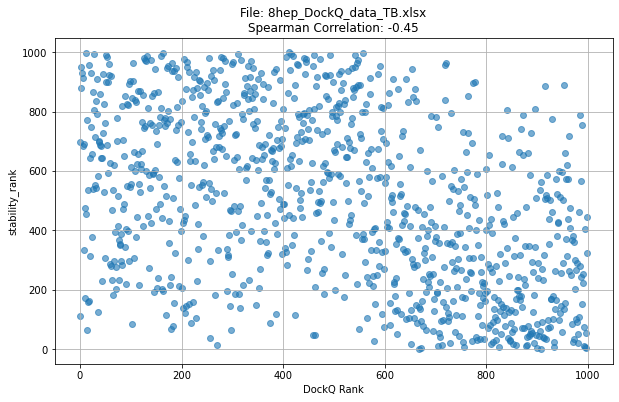

File: 8hep_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.4476591516591517



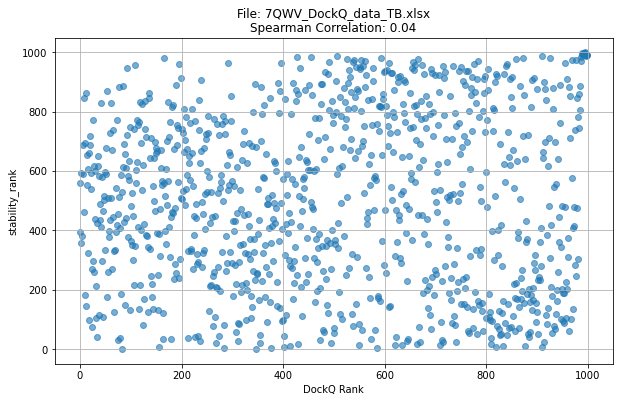

File: 7QWV_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.03502783102783103



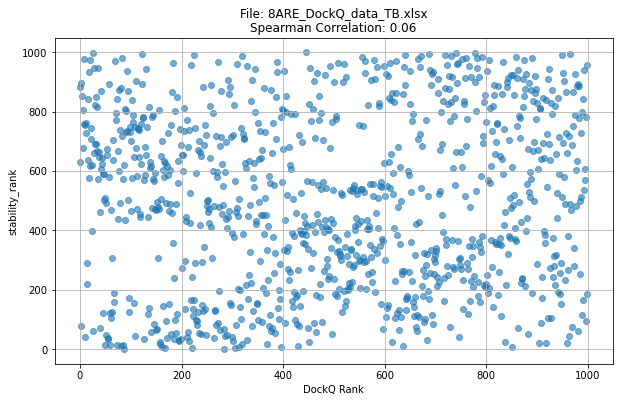

File: 8ARE_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.05924419124419125



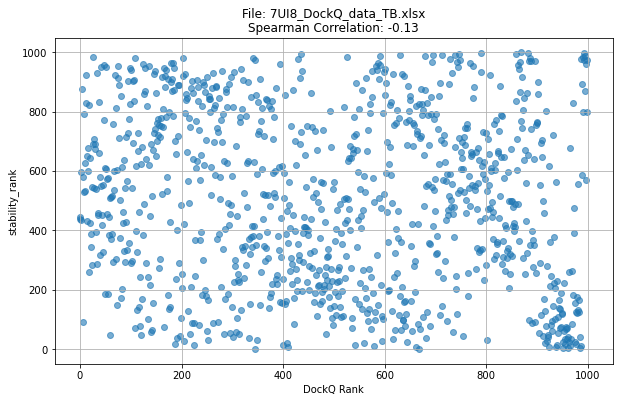

File: 7UI8_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.128995136995137



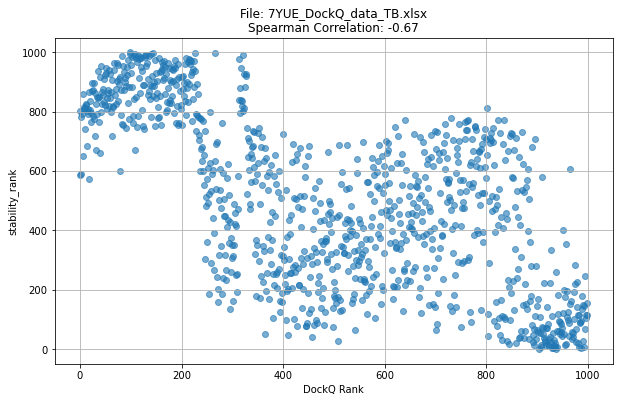

File: 7YUE_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.6670376350376351



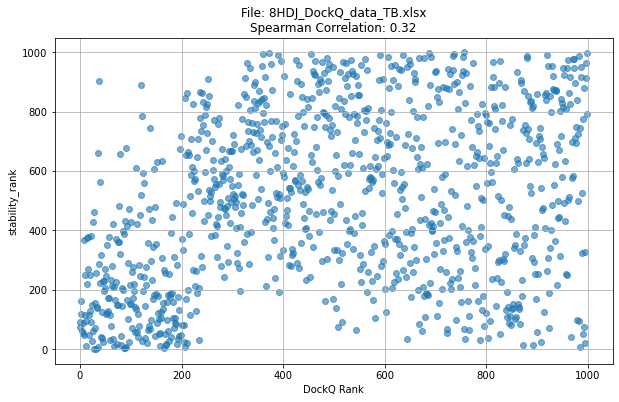

File: 8HDJ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.3178596778596779



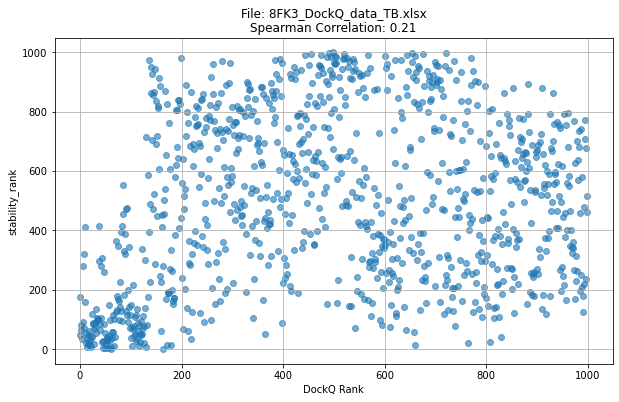

File: 8FK3_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.21031697431697435



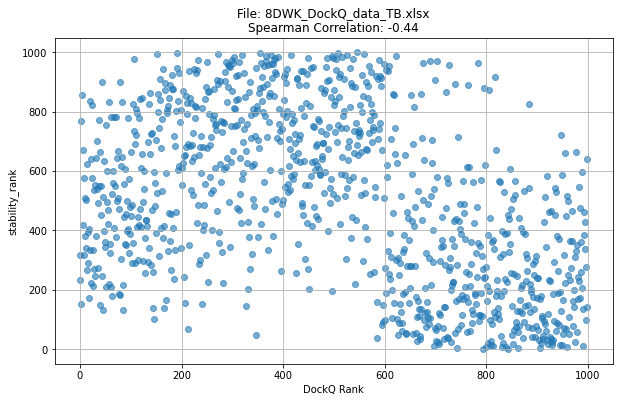

File: 8DWK_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.43804455004455006



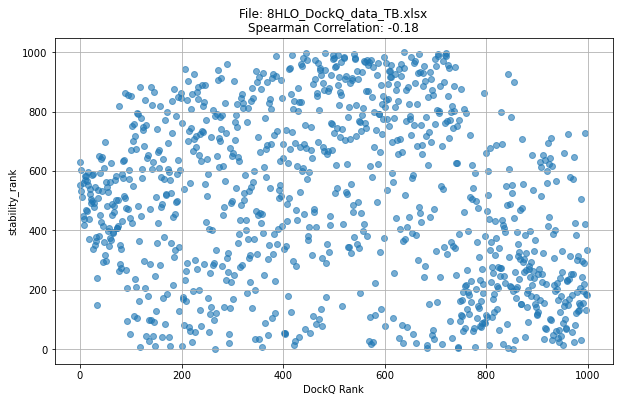

File: 8HLO_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.18151311751311755



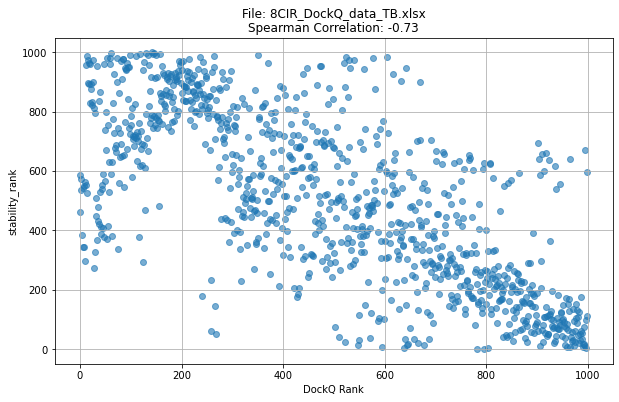

File: 8CIR_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.7309315429315429



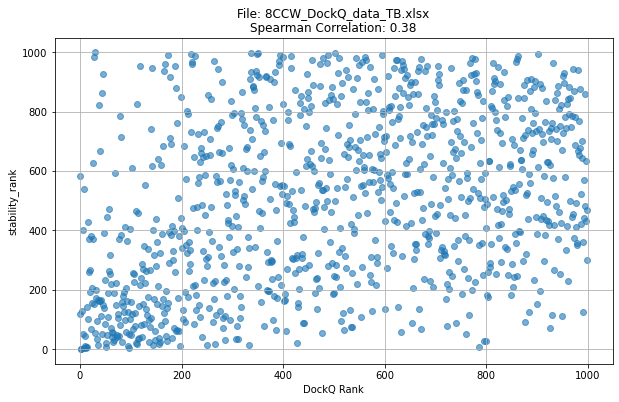

File: 8CCW_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.3783505503505504



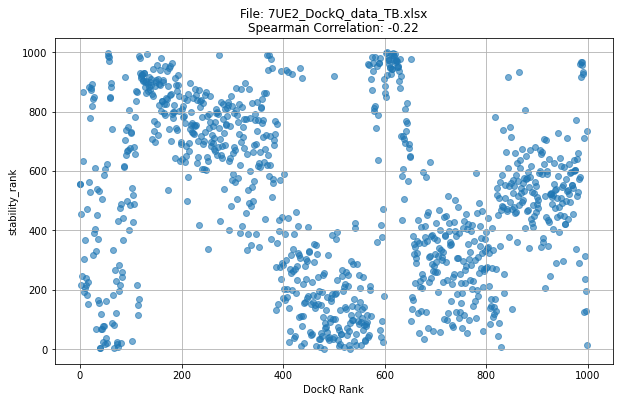

File: 7UE2_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.2241660201660202



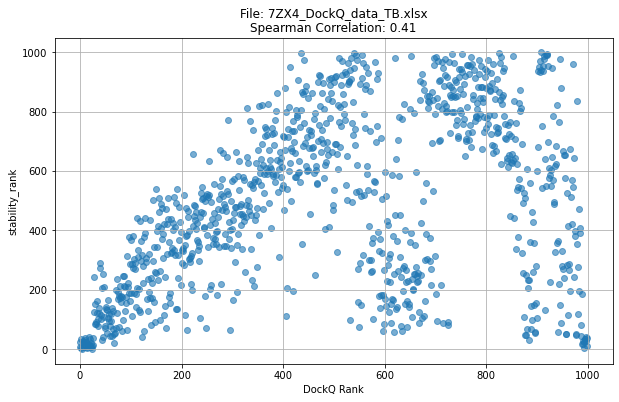

File: 7ZX4_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.40643239043239043



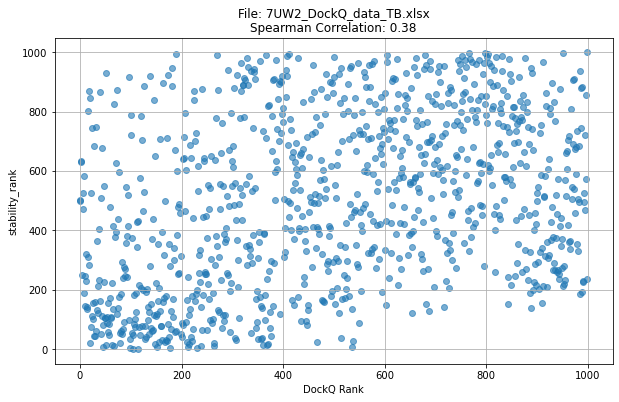

File: 7UW2_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.38034035634035634



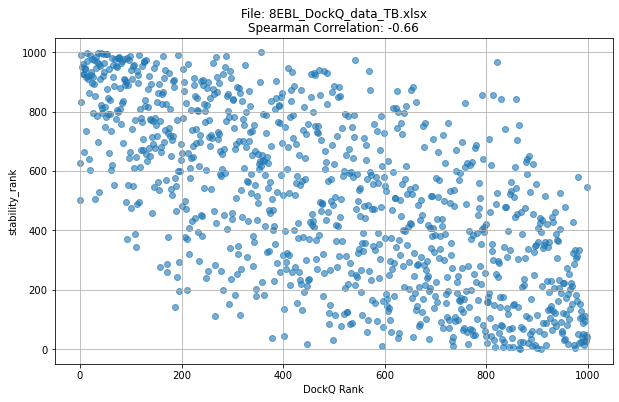

File: 8EBL_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.6617732897732899



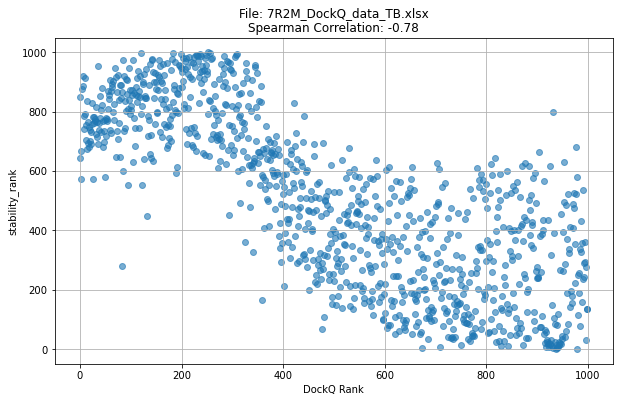

File: 7R2M_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.7800425760425761



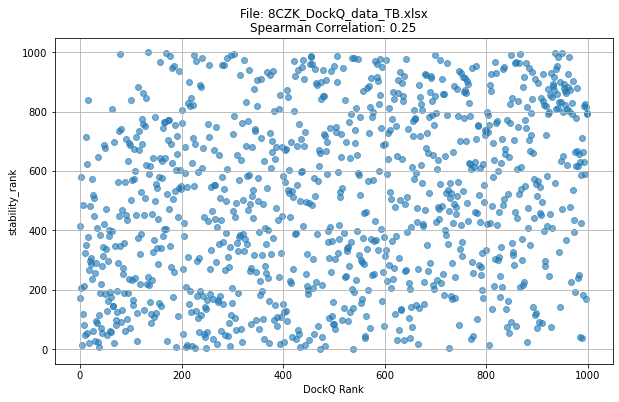

File: 8CZK_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.25193459993459993



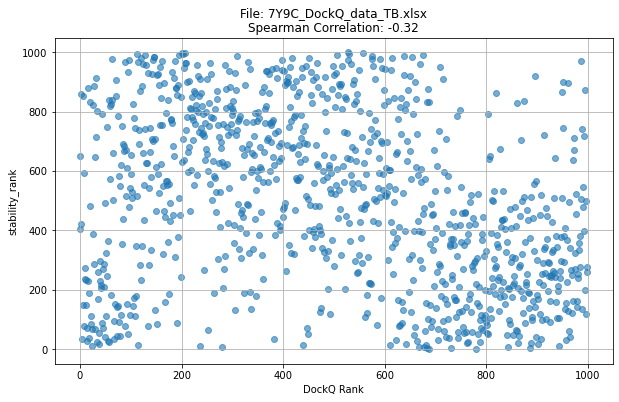

File: 7Y9C_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.3243898803898804



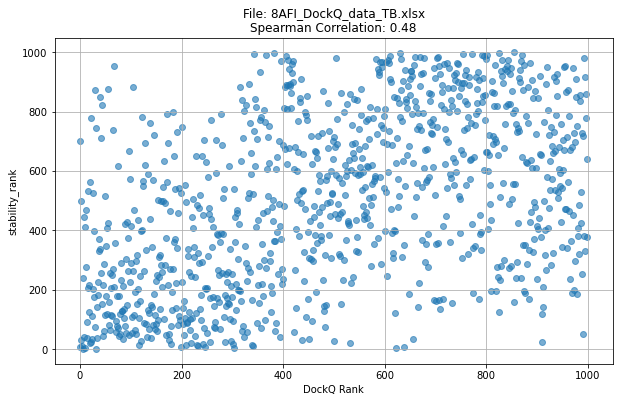

File: 8AFI_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.4785380265380266



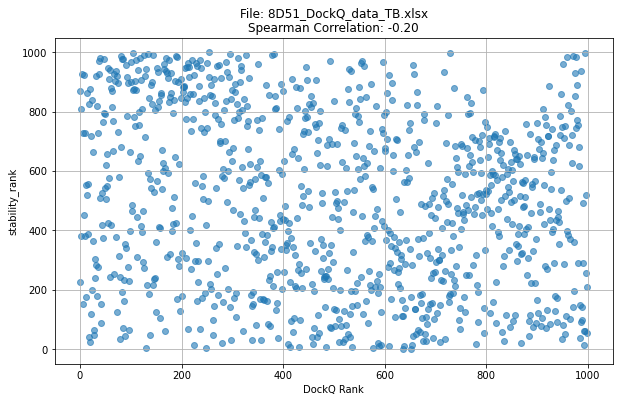

File: 8D51_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.19700382500382504



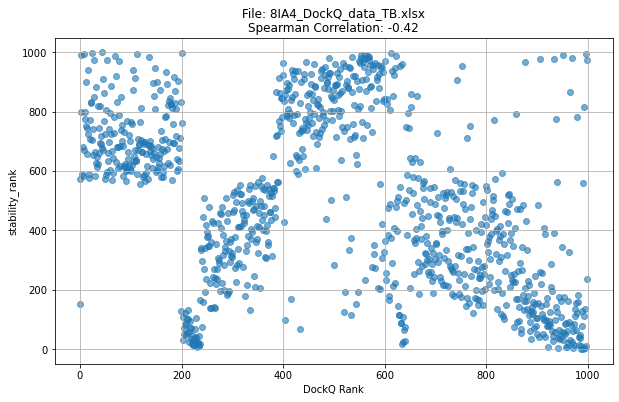

File: 8IA4_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.4182544302544303



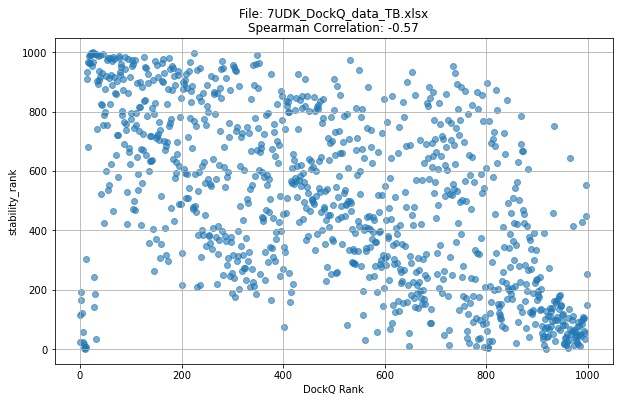

File: 7UDK_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.5665433545433545



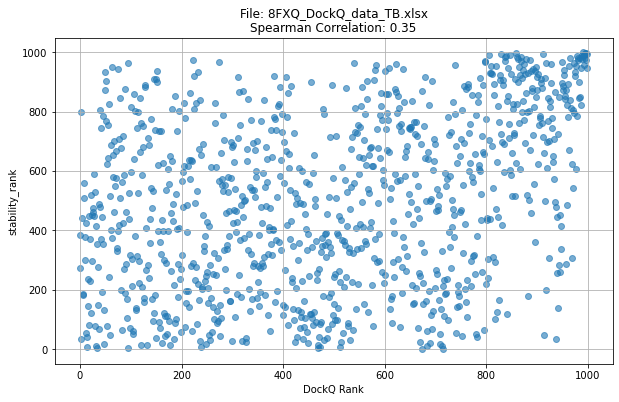

File: 8FXQ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.35059165459165464



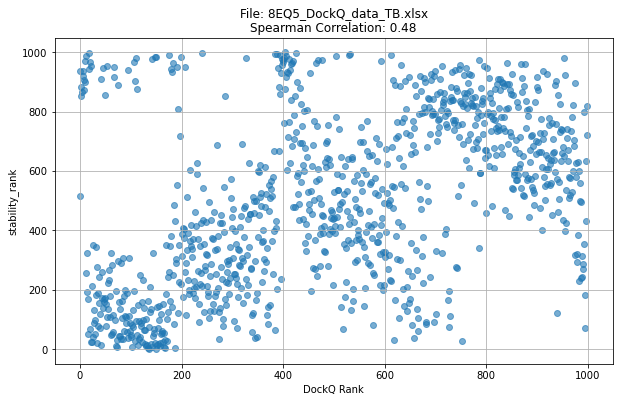

File: 8EQ5_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.4807571767571767



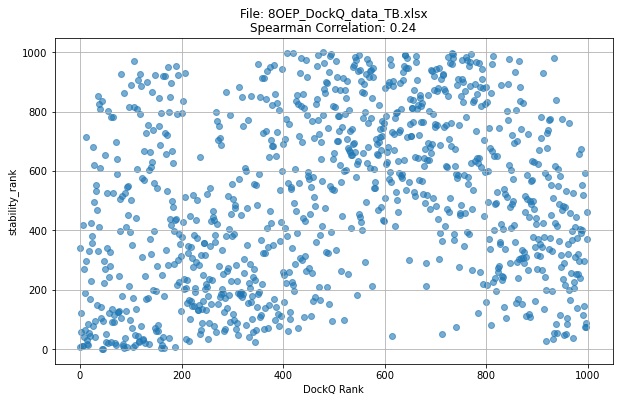

File: 8OEP_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.2388051948051948



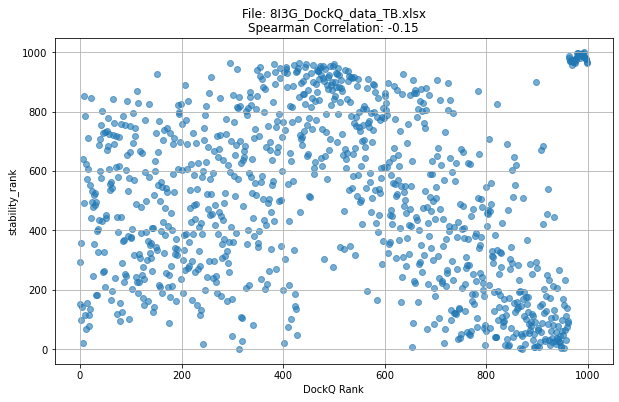

File: 8I3G_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.14671446271446273



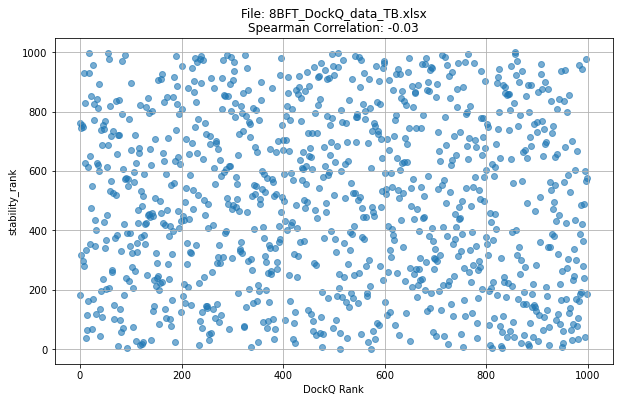

File: 8BFT_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.033470001470001474



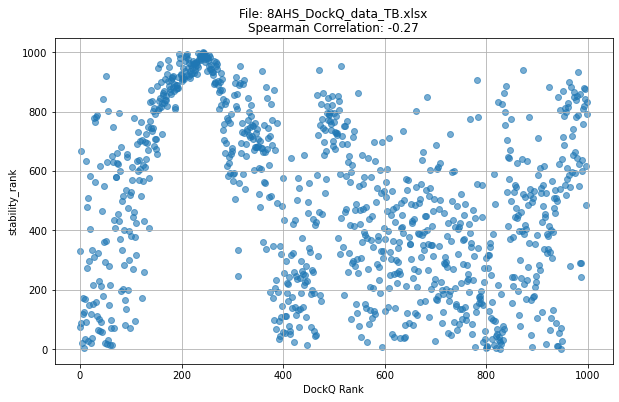

File: 8AHS_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.2744254784254785



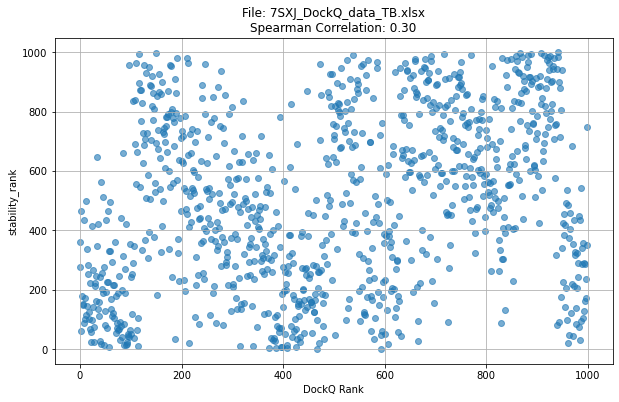

File: 7SXJ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.29664402864402867



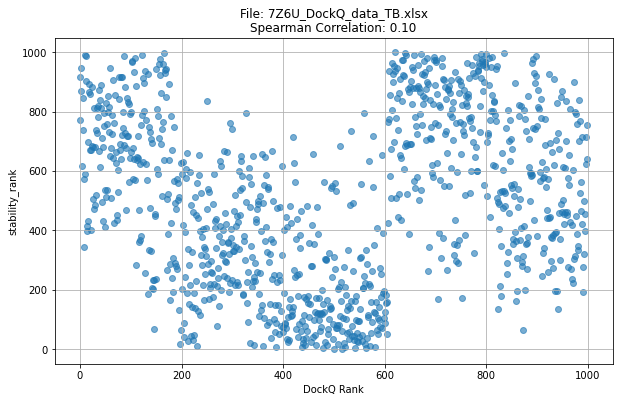

File: 7Z6U_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.09832686232686234



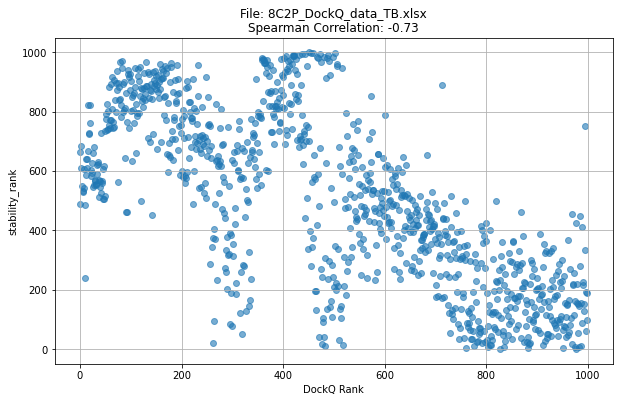

File: 8C2P_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.7306251466251468



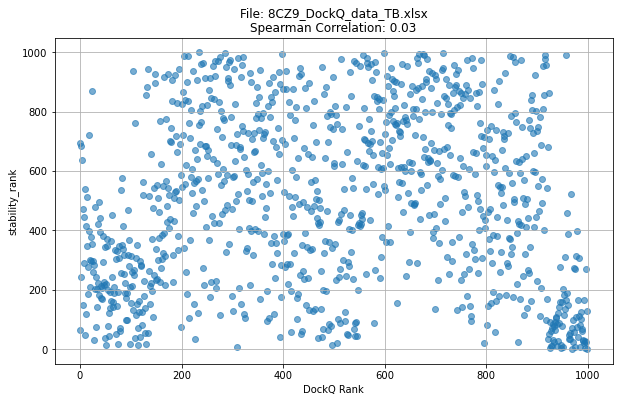

File: 8CZ9_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.034064938064938065



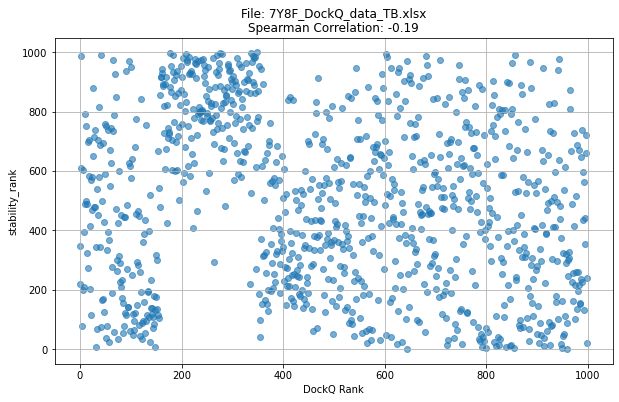

File: 7Y8F_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.18578044178044179



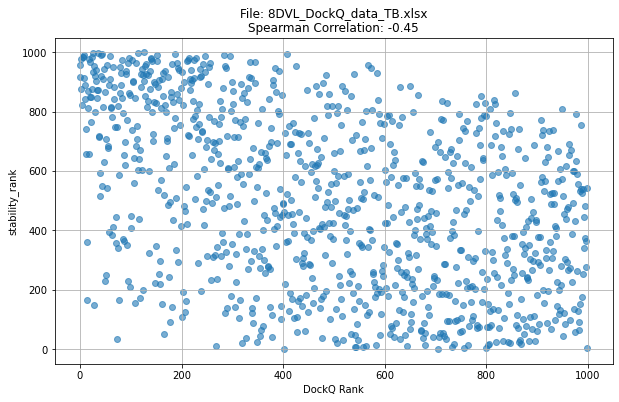

File: 8DVL_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.4472130032130032



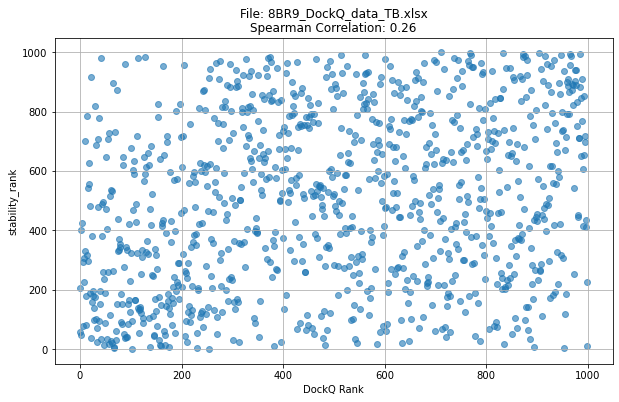

File: 8BR9_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.2626902586902587



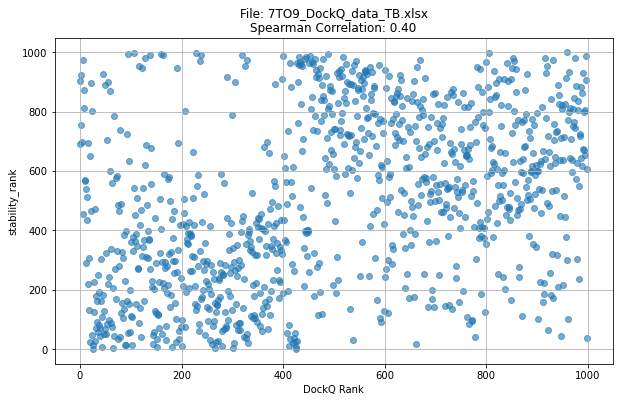

File: 7TO9_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.4041756921756922



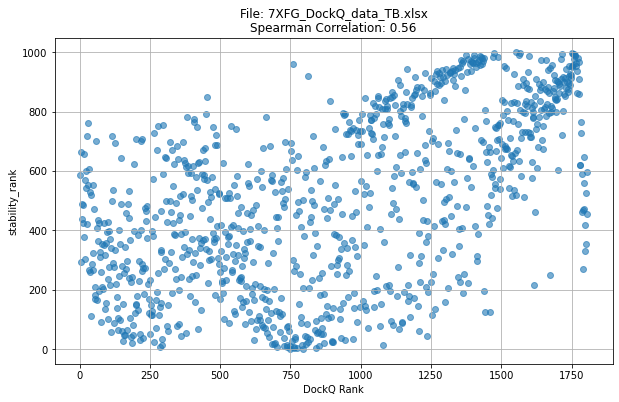

File: 7XFG_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.5635177075177075



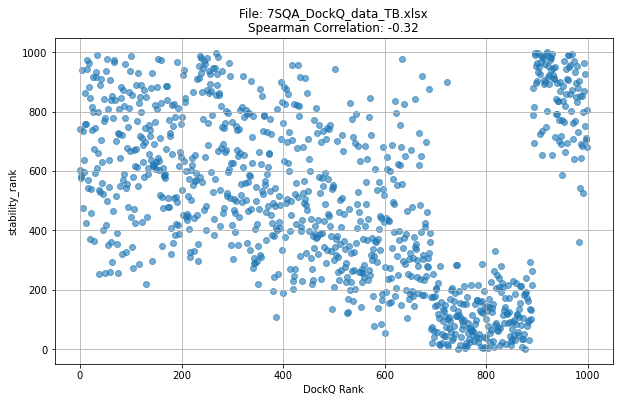

File: 7SQA_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.31502354702354707



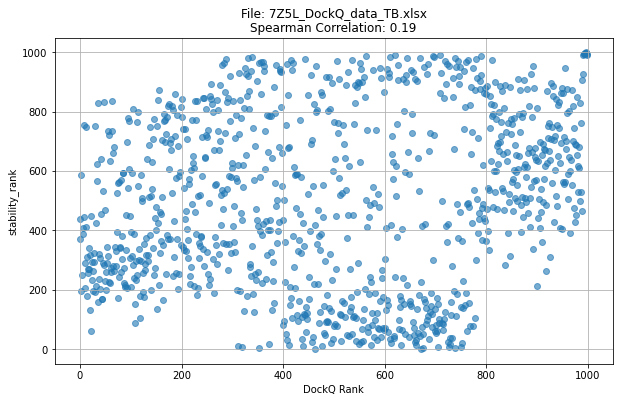

File: 7Z5L_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.1862883062883063



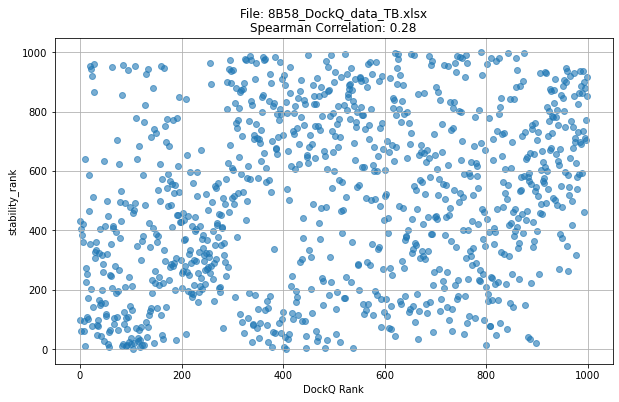

File: 8B58_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.2790815910815911



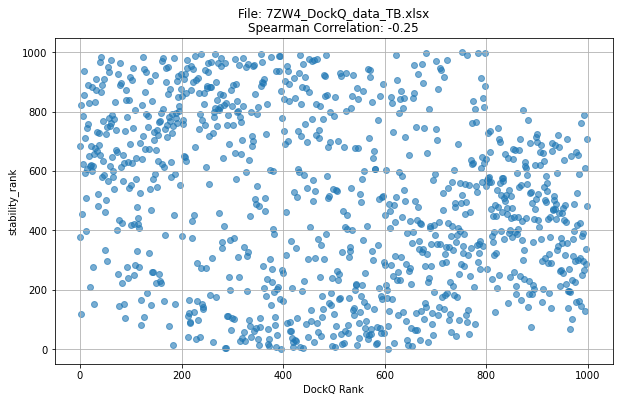

File: 7ZW4_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.25252752052752053

Summary of Spearman correlations saved to /Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TB_Spearman/correlations_stability_TB.xlsx


In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from zipfile import BadZipFile

def process_excel_files(directory_path, output_directory):
    excel_files = [f for f in os.listdir(directory_path) if f.endswith('.xlsx')]
    correlations = []  # To store file names and their Spearman correlations
    
    for excel_file in excel_files:
        excel_file_path = os.path.join(directory_path, excel_file)
        
        try:
            xls = pd.ExcelFile(excel_file_path)
        except BadZipFile:
            print(f'Error: The file "{excel_file}" is not a valid Excel file or is corrupted.')
            continue
        except Exception as e:
            print(f'An unexpected error occurred while processing {excel_file}: {e}')
            continue
        
        if 'Foldx' not in xls.sheet_names:
            print(f'The file "{excel_file}" does not contain a "Foldx" sheet.')
            continue

        dockq_df = pd.read_excel(excel_file_path, sheet_name='Sheet')
        Foldx_df = pd.read_excel(excel_file_path, sheet_name='Foldx')
        
        Foldx_rank_column = 'stability_rank'
        alpha_to_dockq_map = dockq_df.set_index('AlphaFold Rank')['DockQ Rank'].to_dict()
        Foldx_df['DockQ Rank'] = Foldx_df['alphafold rank'].map(alpha_to_dockq_map)
        
        filtered_Foldx_df = Foldx_df.dropna(subset=['DockQ Rank'])
        
        spearman_corr, _ = spearmanr(filtered_Foldx_df[Foldx_rank_column], filtered_Foldx_df['DockQ Rank'])
        
        plt.figure(figsize=(10, 6))
        plt.scatter(filtered_Foldx_df['DockQ Rank'], filtered_Foldx_df[Foldx_rank_column], alpha=0.6)
        plt.title(f'File: {excel_file}\nSpearman Correlation: {spearman_corr:.2f}')
        plt.xlabel('DockQ Rank')
        plt.ylabel('stability_rank')
        plt.grid(True)
        plt.show()

        # Append file name and Spearman correlation to the list
        correlations.append({'File Name': excel_file, 'Spearman Correlation': spearman_corr})
        print(f'File: {excel_file}\nSpearman Correlation Coefficient: {spearman_corr}\n')
    
    # Convert list to DataFrame
    correlations_df = pd.DataFrame(correlations)
    
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Path for the new Excel file
    output_file_path = os.path.join(output_directory, 'correlations_stability_TB.xlsx')
    
    # Save DataFrame to an Excel file
    correlations_df.to_excel(output_file_path, index=False)
    print(f'Summary of Spearman correlations saved to {output_file_path}')

# Example usage
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/stability_TB'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TB_Spearman'
process_excel_files(directory_path, output_directory)



In [6]:
import pandas as pd

def calculate_positive_negative_percentages_and_average(file_path):
    # Load the Excel file
    data = pd.read_excel(file_path)
    
    # Count the total number of entries
    total_entries = len(data['Spearman Correlation'])
    
    # Count the number of positive and negative Foldx_Spearman Correlation values
    positive_count = data[data['Spearman Correlation'] > 0].shape[0]
    negative_count = data[data['Spearman Correlation'] < 0].shape[0]
    
    # Calculate percentages
    positive_percentage = (positive_count / total_entries) * 100
    negative_percentage = (negative_count / total_entries) * 100
    
    # Calculate the average of Foldx_Spearman Correlation values
    average_correlation = data['Spearman Correlation'].mean()
    
    return positive_percentage, negative_percentage, average_correlation

# Example usage
file_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TB_Spearman/correlations_stability_TB.xlsx'  # Replace with your actual file path
positive_percentage, negative_percentage, average_correlation = calculate_positive_negative_percentages_and_average(file_path)
print(f"Positive Foldx_Spearman Correlation: {positive_percentage:.2f}%")
print(f"Negative Foldx_Spearman Correlation: {negative_percentage:.2f}%")
print(f"Average Foldx_Spearman Correlation: {average_correlation:.2f}")


Positive Foldx_Spearman Correlation: 50.00%
Negative Foldx_Spearman Correlation: 50.00%
Average Foldx_Spearman Correlation: -0.01


In [16]:
import os
import pandas as pd

# Directory containing the Excel files
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/stability_TB'

# Initialize a list to store the results
results = []

# List all Excel files in the directory
excel_files = [file for file in os.listdir(directory_path) if file.endswith('.xlsx')]

for file_name in excel_files:
    file_path = os.path.join(directory_path, file_name)
    xls = pd.ExcelFile(file_path)

    # Extract pdb_id from file name
    pdb_id = file_name.split('_')[0]

    # Load data from "Foldx" sheet
    foldx_df = pd.read_excel(file_path, sheet_name='Foldx')
    structure_name_for_rank_zero = foldx_df[foldx_df['stability_rank'] == 0]['Unnamed: 0'].iloc[0].replace('_clean.pdb', '')

    # Load data from "Sheet" sheet
    sheet_df = pd.read_excel(file_path, sheet_name='Sheet')

    # Highest DockQ score
    highest_dockq_score = sheet_df['DockQ'].max()

    # DockQ score for the structure from Foldx
    highest_foldx_dockq_score = sheet_df[sheet_df['File Name'].str.contains(structure_name_for_rank_zero)]['DockQ'].max()

    # Calculate Loss
    score_Loss = highest_dockq_score - highest_foldx_dockq_score

    # Append results
    results.append([pdb_id, highest_dockq_score, highest_foldx_dockq_score, score_Loss])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['File Name', 'DockQ', 'Foldx/Stability ranked', 'Loss'])

# Save the results into a new Excel file
output_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Loss/TB_Loss/Foldx_stability_TB.xlsx'
results_df.to_excel(output_path, index=False)

print(f"Results have been saved to {output_path}")



Results have been saved to /Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Loss/TB_Loss/Foldx_stability_TB.xlsx


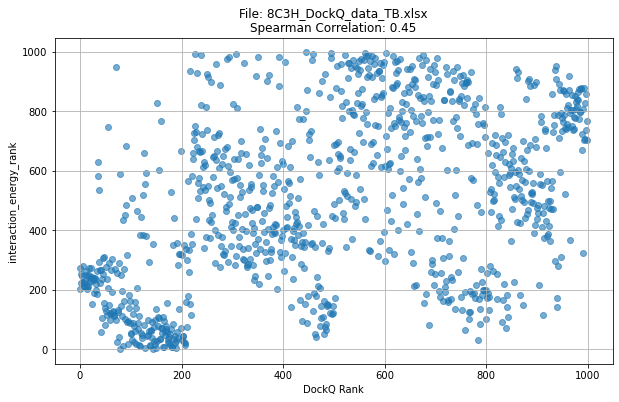

File: 8C3H_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.4514547533505449



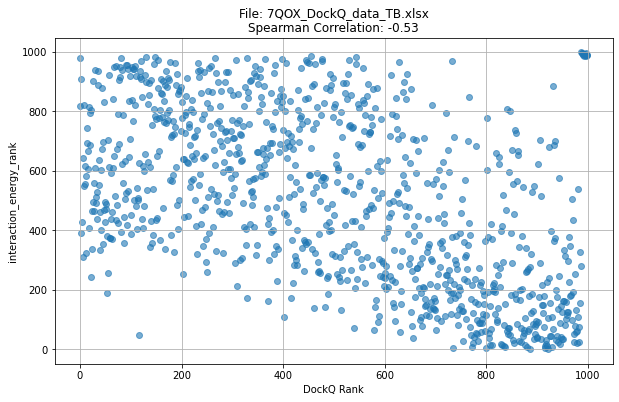

File: 7QOX_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.5317420667160145



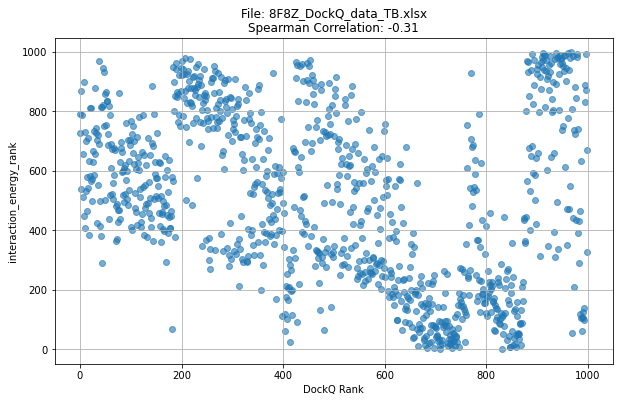

File: 8F8Z_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.30557048029993916



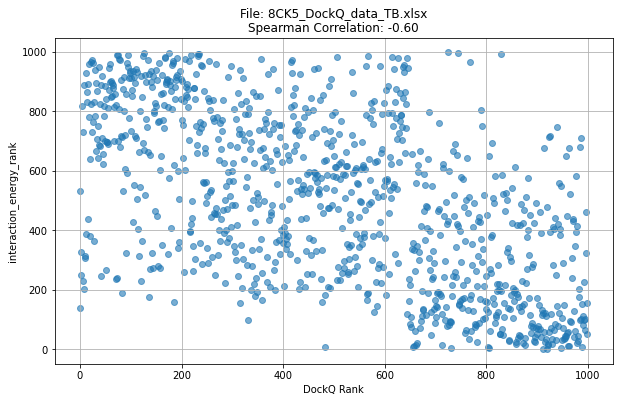

File: 8CK5_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.5982849422568861



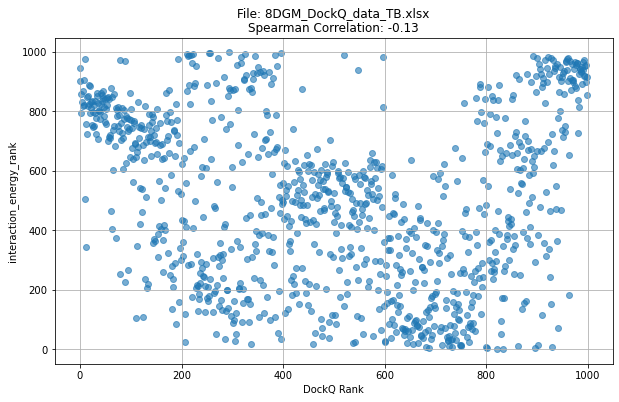

File: 8DGM_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.13314817021430245



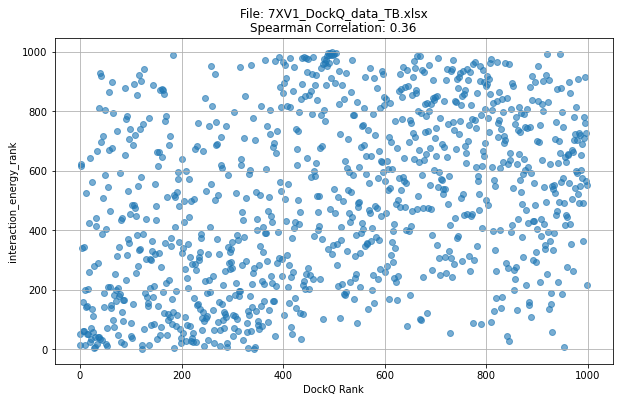

File: 7XV1_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.36051945332105645



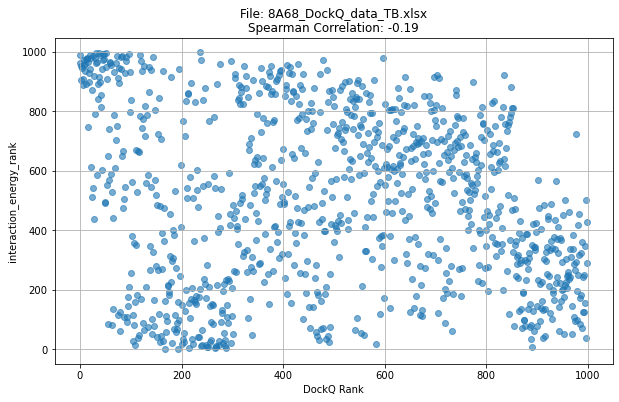

File: 8A68_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.18542002924768455



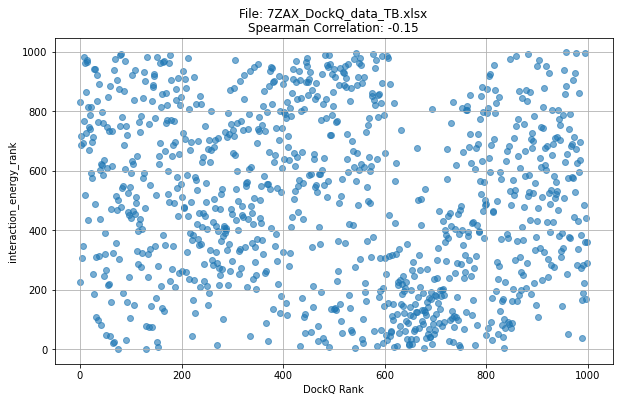

File: 7ZAX_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.14636196115955633



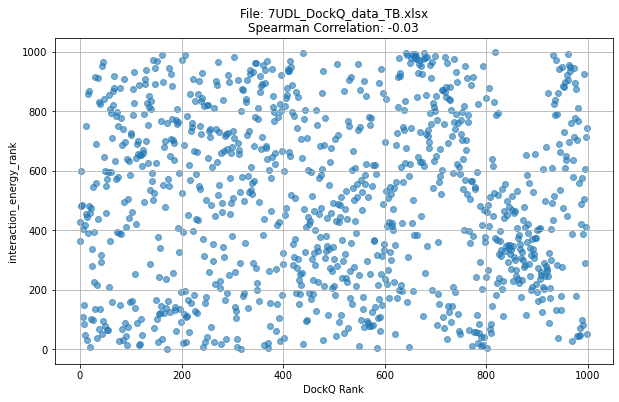

File: 7UDL_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.026353078529431233



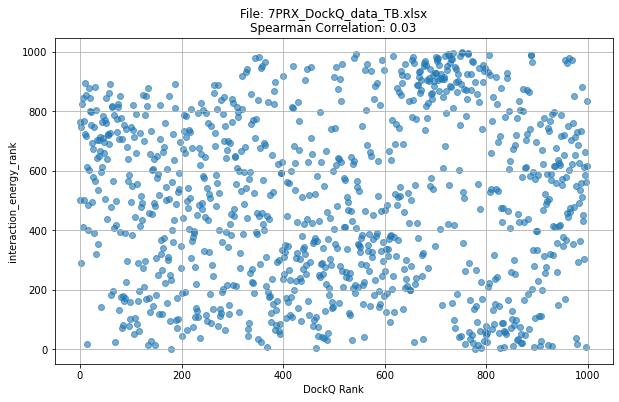

File: 7PRX_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.03240968423333153



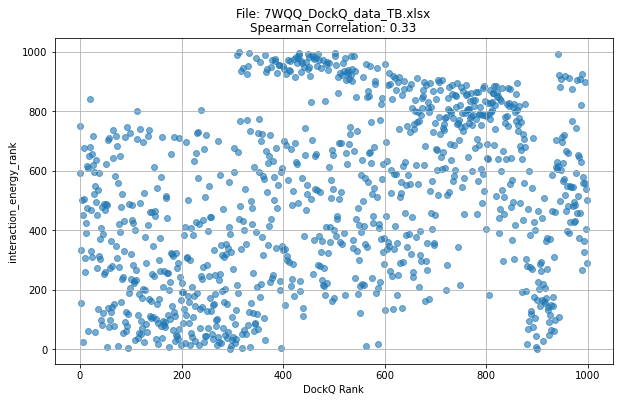

File: 7WQQ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.329906852744528



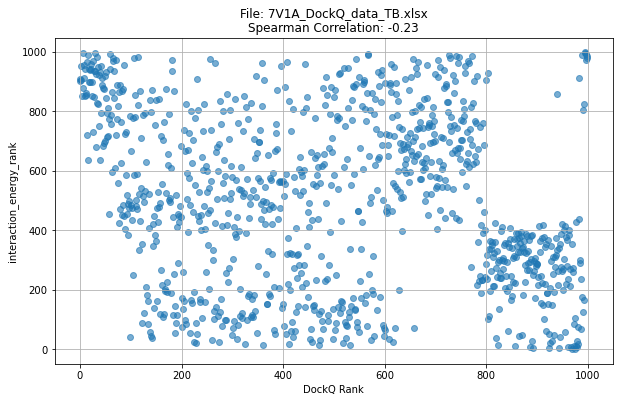

File: 7V1A_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.2251259395668213



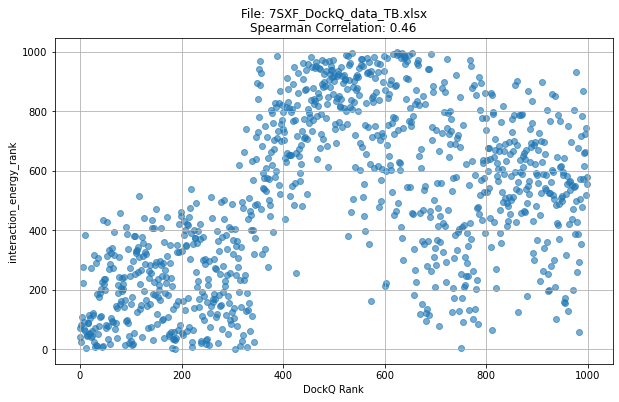

File: 7SXF_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.4619150252456865



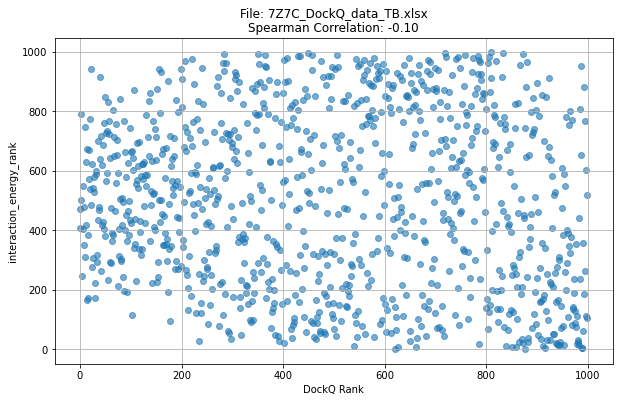

File: 7Z7C_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.09786513567675892



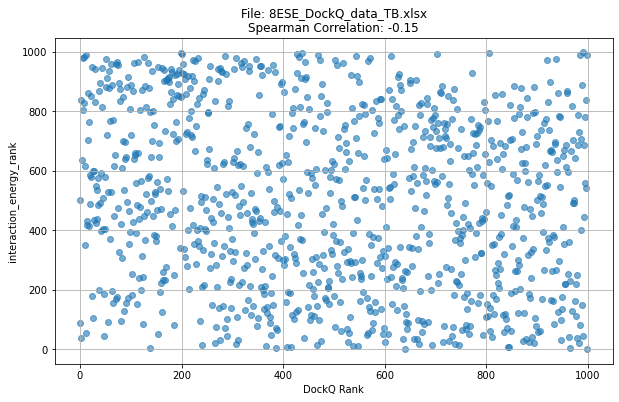

File: 8ESE_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.15408936792503924



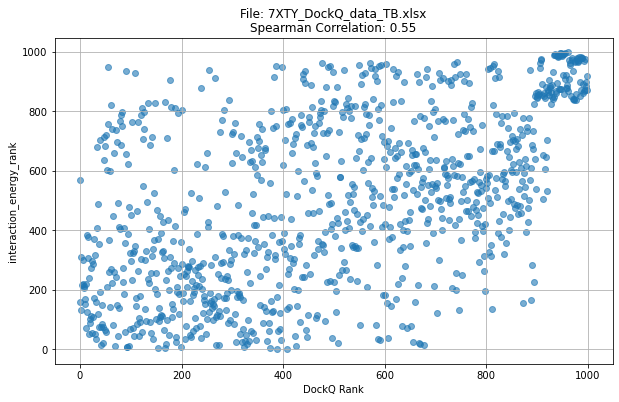

File: 7XTY_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.5514631665733869



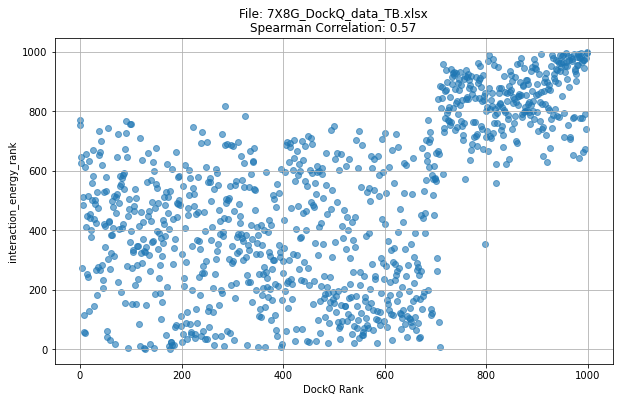

File: 7X8G_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.5661527138360805



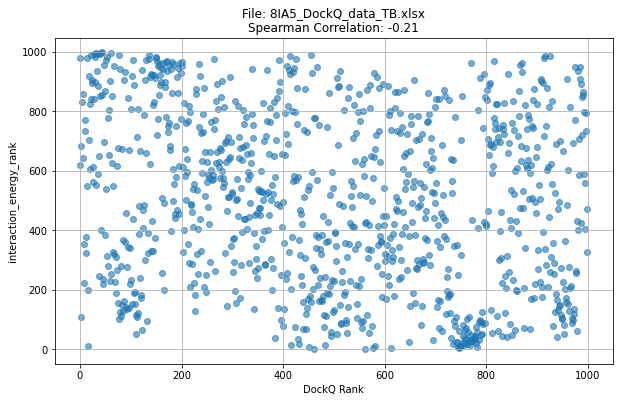

File: 8IA5_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.21079782387598014



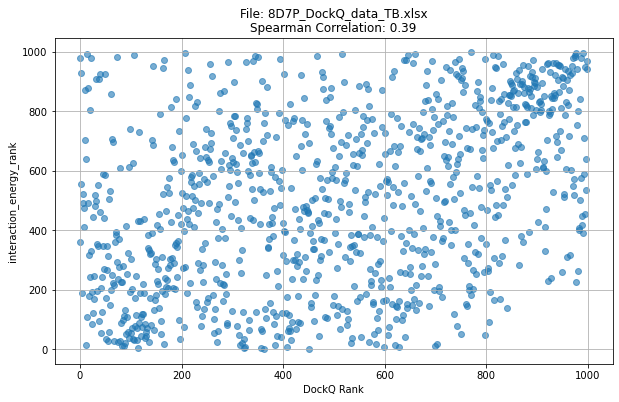

File: 8D7P_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.39179060824351397



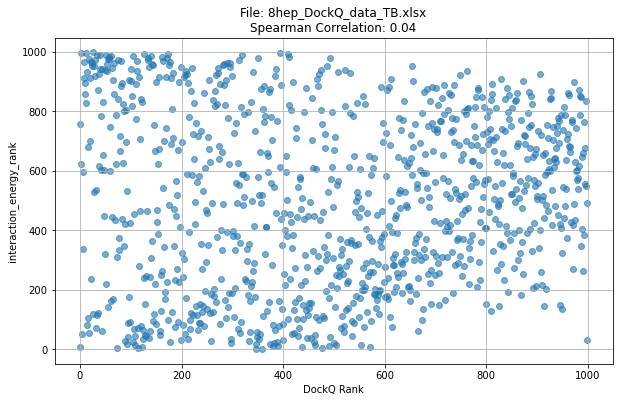

File: 8hep_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.03905038906642112



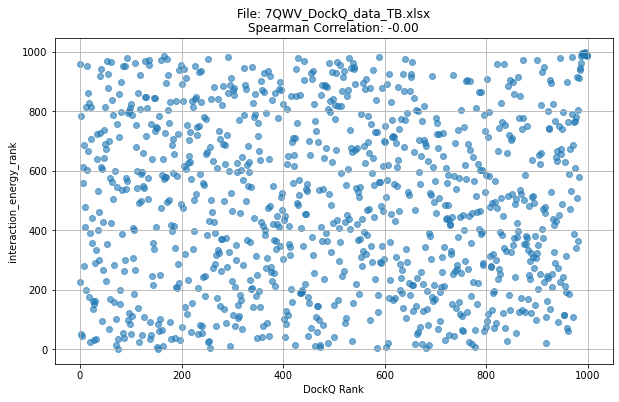

File: 7QWV_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.0015208795970319015



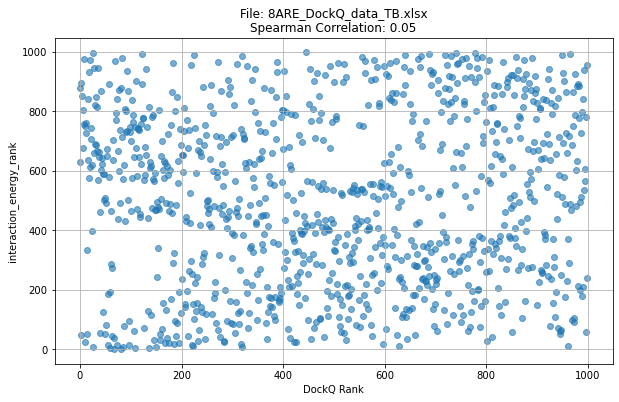

File: 8ARE_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.053883274055618734



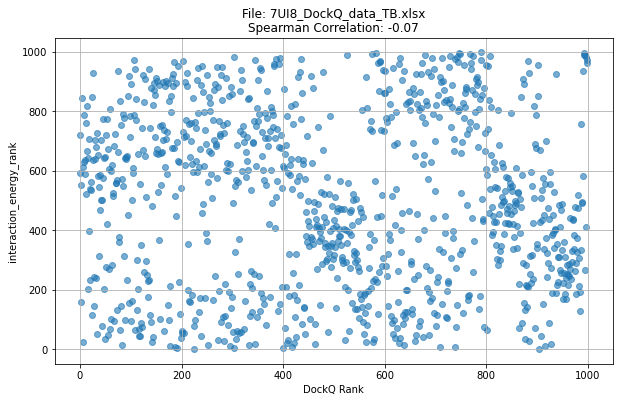

File: 7UI8_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.06951156366787628



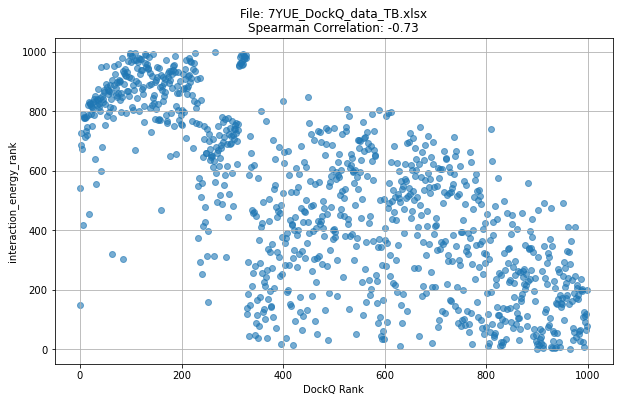

File: 7YUE_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.7261537248671517



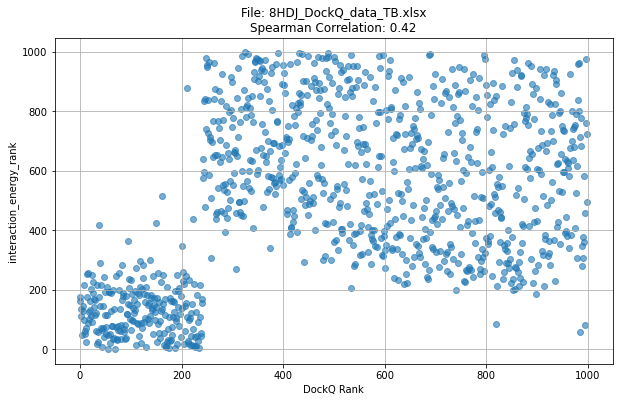

File: 8HDJ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.42393020274783794



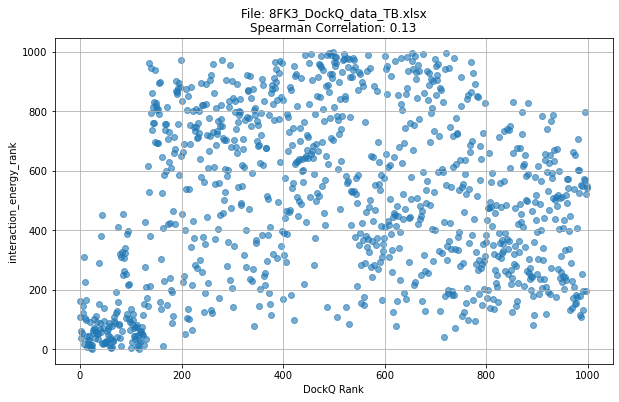

File: 8FK3_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.12777742873133652



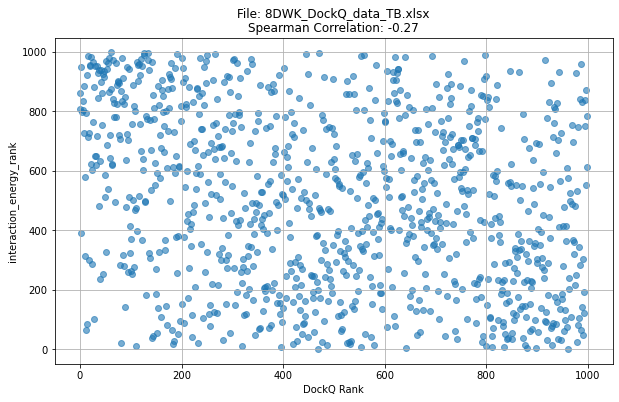

File: 8DWK_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.27177849994282854



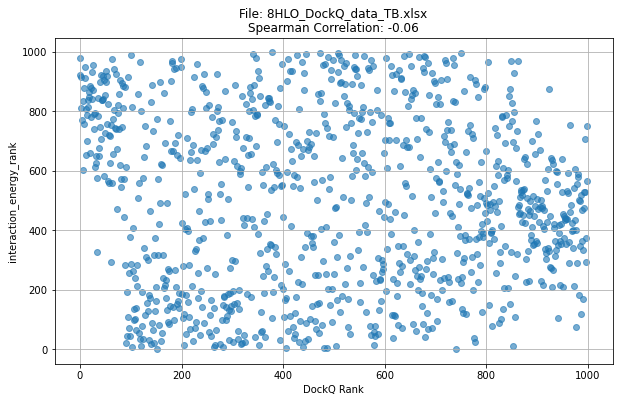

File: 8HLO_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.06445981452394277



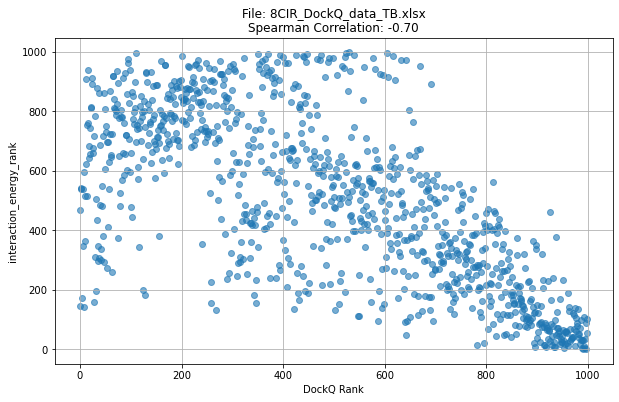

File: 8CIR_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.7040708925358222



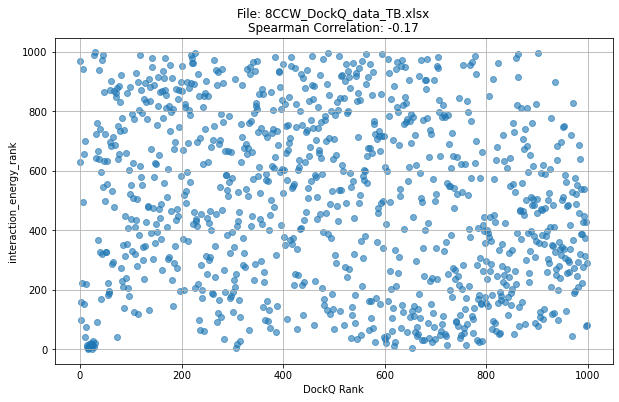

File: 8CCW_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.16941763406693264



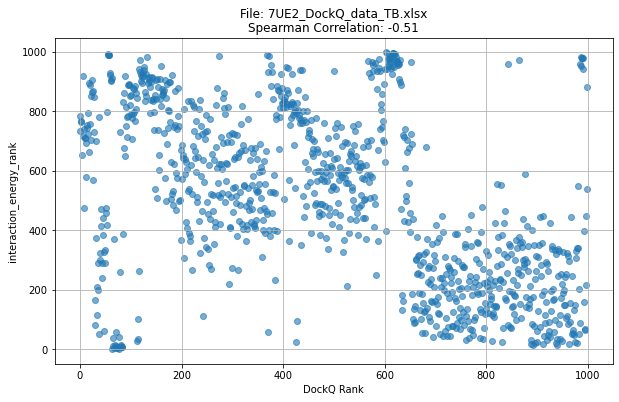

File: 7UE2_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.5066076657820143



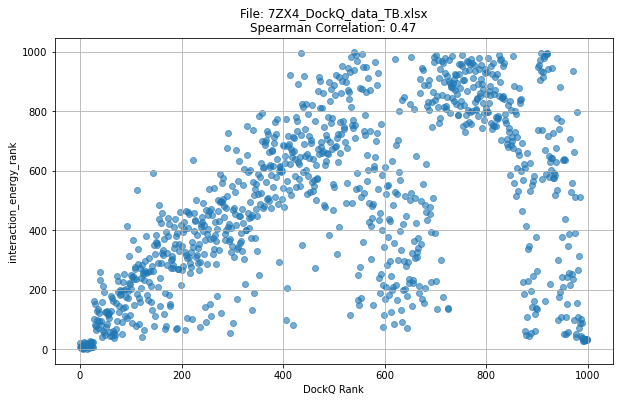

File: 7ZX4_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.4727017037077157



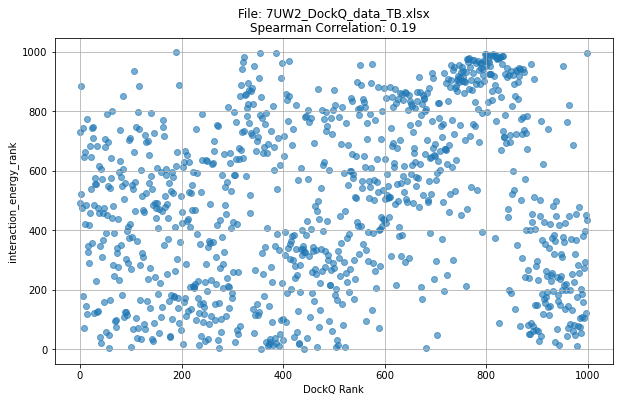

File: 7UW2_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.1869012499473421



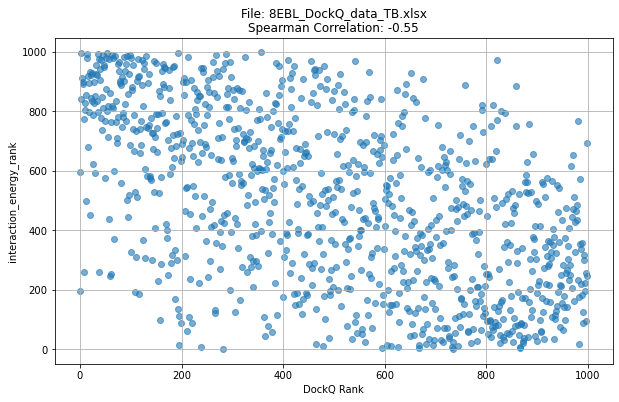

File: 8EBL_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.5534221957428369



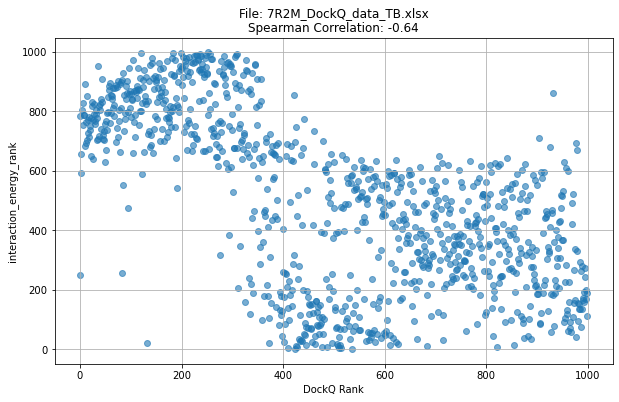

File: 7R2M_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.6433091889484674



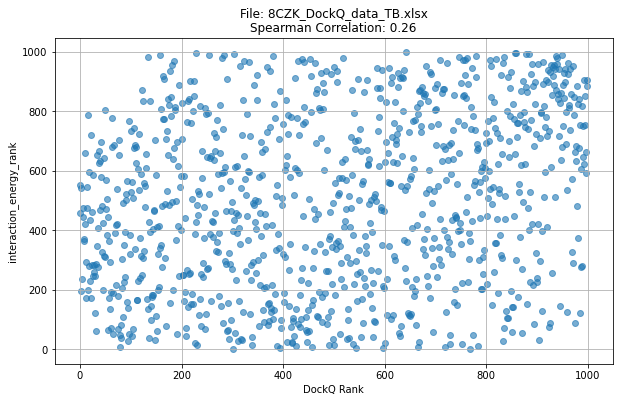

File: 8CZK_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.25775244182057805



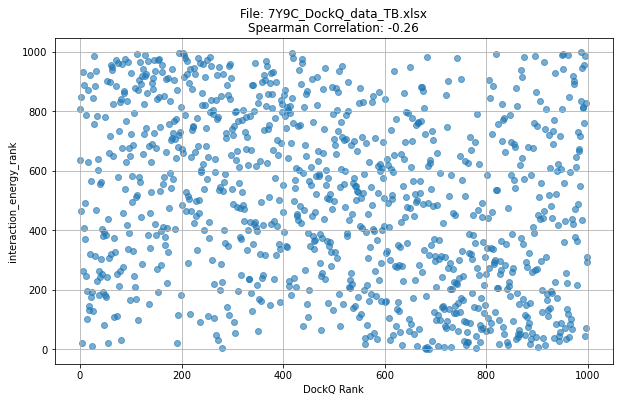

File: 7Y9C_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.26218107085040954



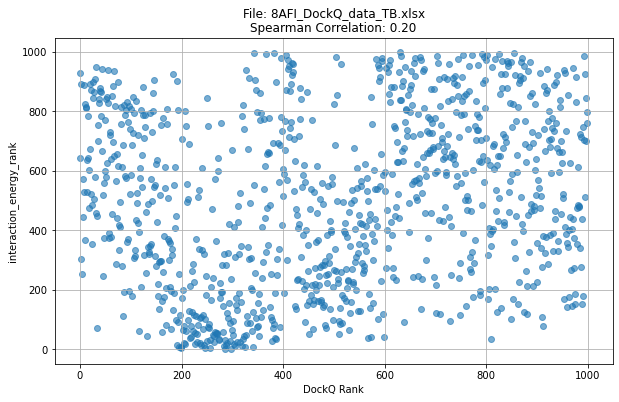

File: 8AFI_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.1988651296587168



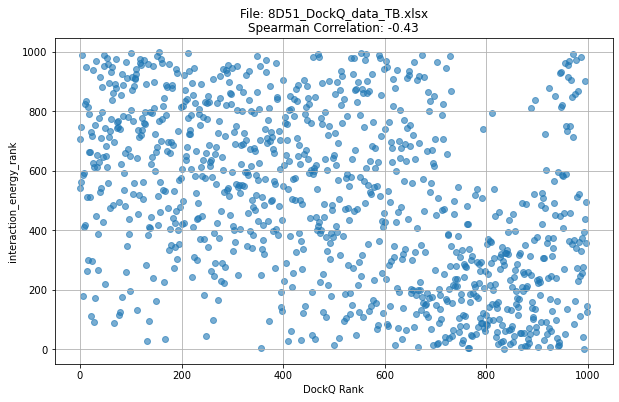

File: 8D51_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.42690889286079664



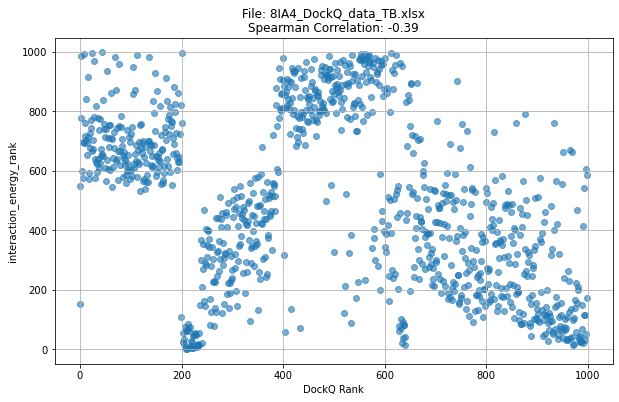

File: 8IA4_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.39256182033737136



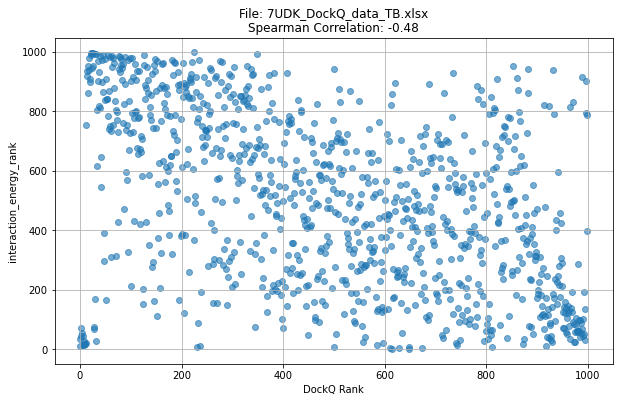

File: 7UDK_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.4758799520963849



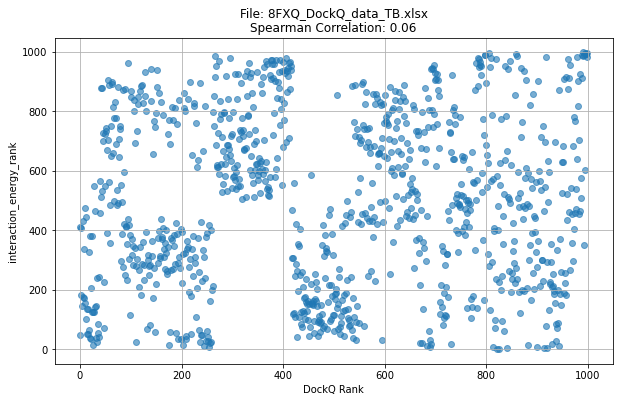

File: 8FXQ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.05537947968008088



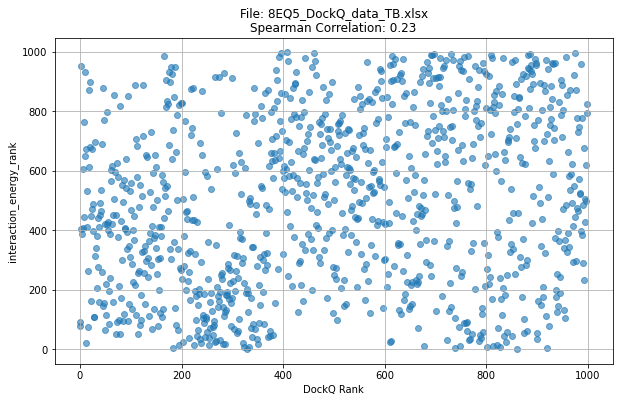

File: 8EQ5_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.23466109395969115



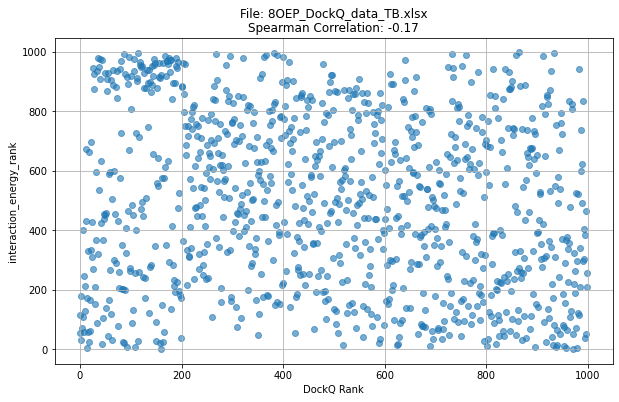

File: 8OEP_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.16853400494683057



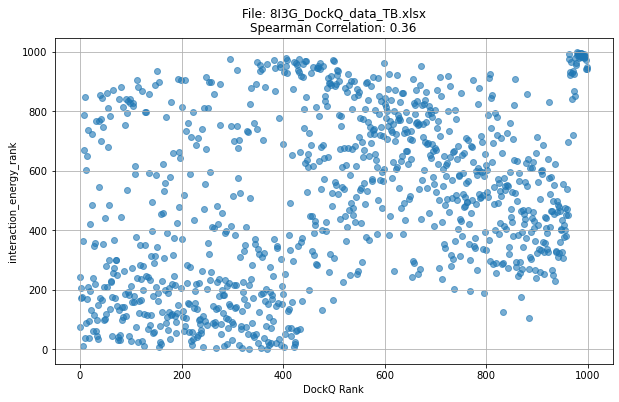

File: 8I3G_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.35728372059434177



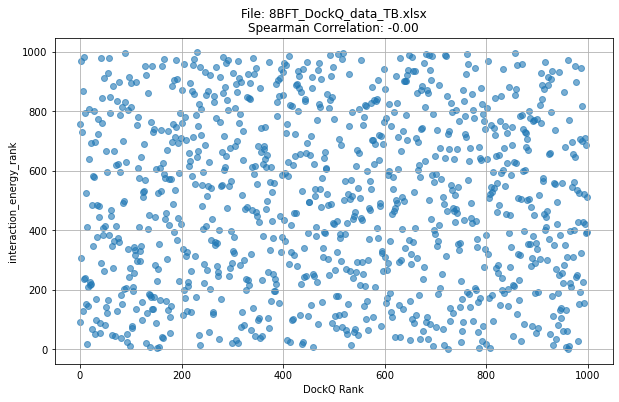

File: 8BFT_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.0018547003917745396



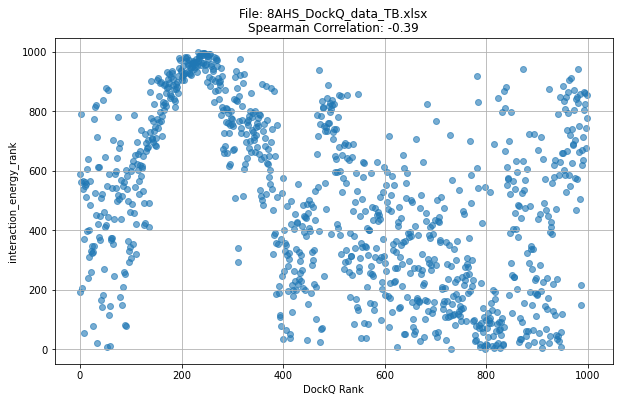

File: 8AHS_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.3936347529894624



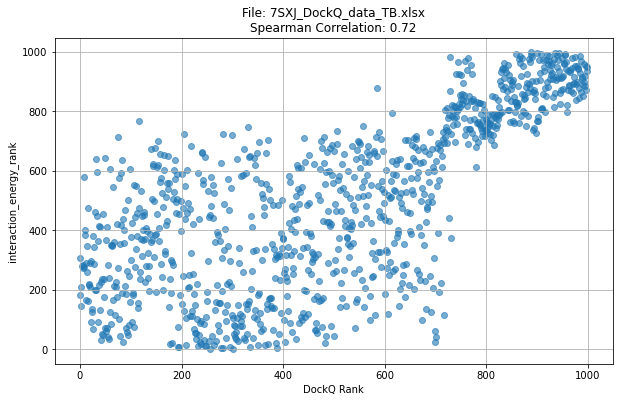

File: 7SXJ_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.7189574825326327



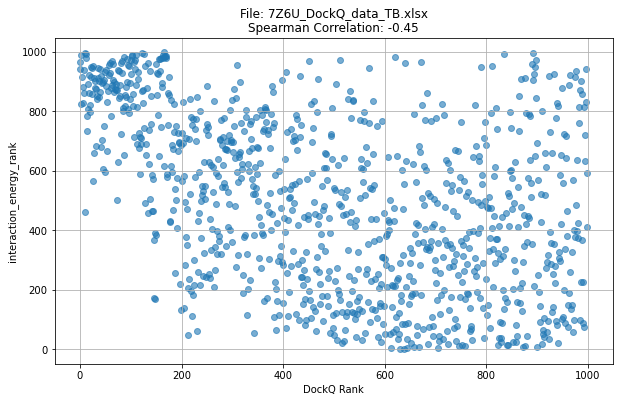

File: 7Z6U_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.4517146605523359



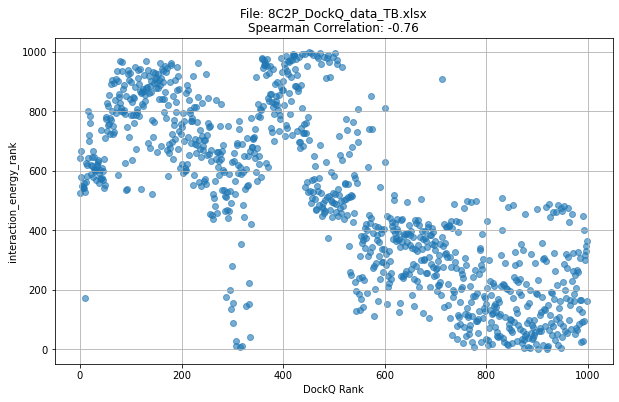

File: 8C2P_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.7623580373961134



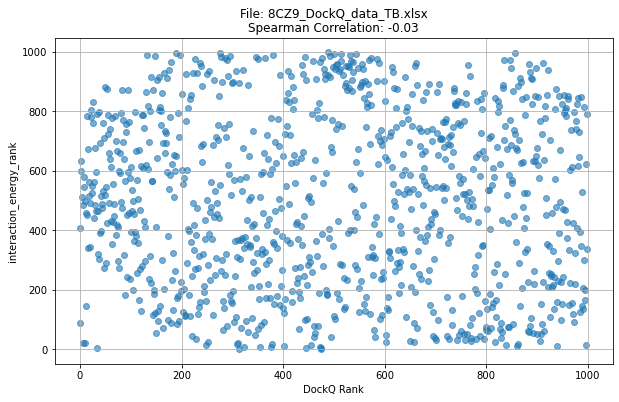

File: 8CZ9_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.02572333856902995



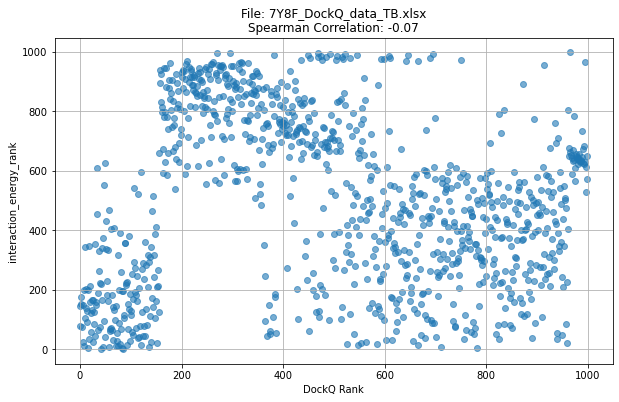

File: 7Y8F_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.07286914971083307



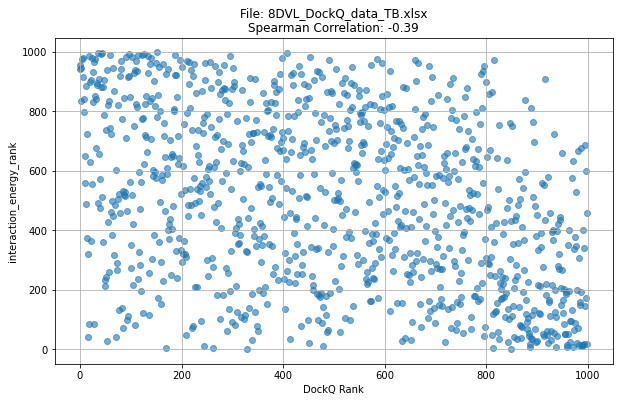

File: 8DVL_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.3870481623908477



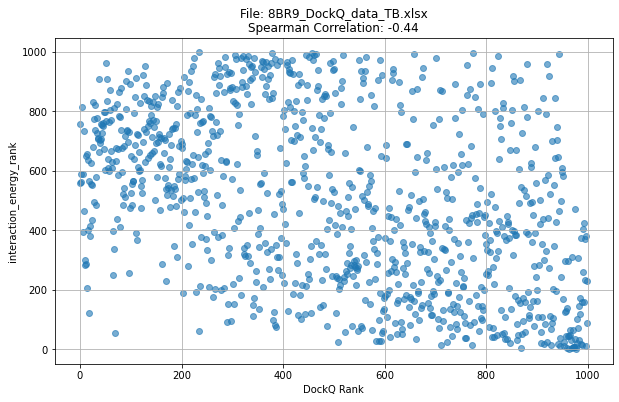

File: 8BR9_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.4396111141201321



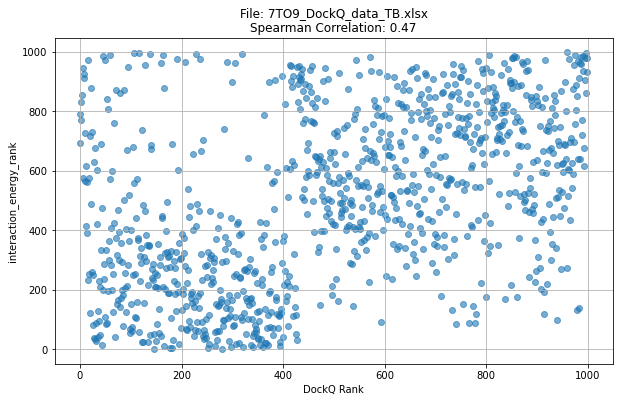

File: 7TO9_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.46735904240914256



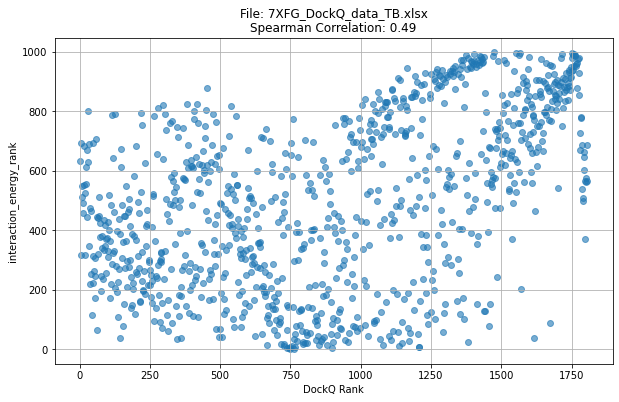

File: 7XFG_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.49140225195135007



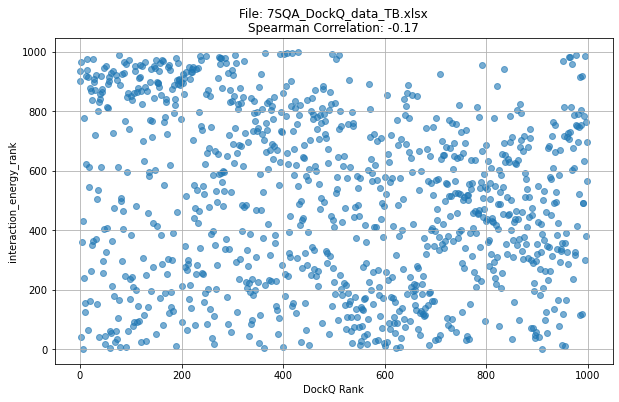

File: 7SQA_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.17267479102348837



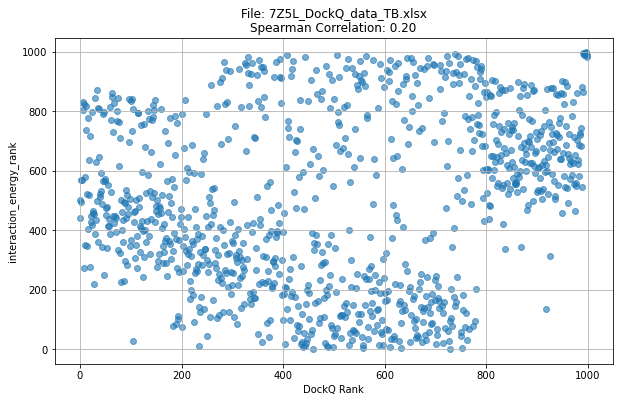

File: 7Z5L_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.20179127022814394



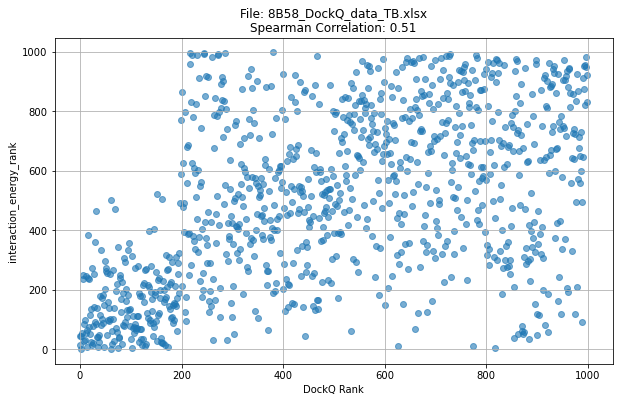

File: 8B58_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: 0.5078059061065072



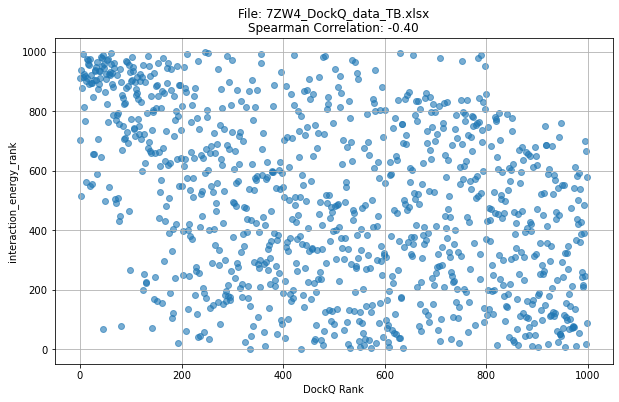

File: 7ZW4_DockQ_data_TB.xlsx
Spearman Correlation Coefficient: -0.39757677517196555

Summary of Spearman correlations saved to /Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TB_Spearman/correlations_Interaction_TB.xlsx


In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from zipfile import BadZipFile

def process_excel_files(directory_path, output_directory):
    excel_files = [f for f in os.listdir(directory_path) if f.endswith('.xlsx')]
    correlations = []  # To store file names and their Spearman correlations
    
    for excel_file in excel_files:
        excel_file_path = os.path.join(directory_path, excel_file)
        
        try:
            xls = pd.ExcelFile(excel_file_path)
        except BadZipFile:
            print(f'Error: The file "{excel_file}" is not a valid Excel file or is corrupted.')
            continue
        except Exception as e:
            print(f'An unexpected error occurred while processing {excel_file}: {e}')
            continue
        
        if 'Foldx' not in xls.sheet_names:
            print(f'The file "{excel_file}" does not contain a "Foldx" sheet.')
            continue

        dockq_df = pd.read_excel(excel_file_path, sheet_name='Sheet')
        Foldx_df = pd.read_excel(excel_file_path, sheet_name='Foldx')
        
        Foldx_rank_column = 'interaction_energy_rank'
        alpha_to_dockq_map = dockq_df.set_index('AlphaFold Rank')['DockQ Rank'].to_dict()
        Foldx_df['DockQ Rank'] = Foldx_df['alphafold rank'].map(alpha_to_dockq_map)
        
        filtered_Foldx_df = Foldx_df.dropna(subset=['DockQ Rank'])
        
        spearman_corr, _ = spearmanr(filtered_Foldx_df[Foldx_rank_column], filtered_Foldx_df['DockQ Rank'])
        
        plt.figure(figsize=(10, 6))
        plt.scatter(filtered_Foldx_df['DockQ Rank'], filtered_Foldx_df[Foldx_rank_column], alpha=0.6)
        plt.title(f'File: {excel_file}\nSpearman Correlation: {spearman_corr:.2f}')
        plt.xlabel('DockQ Rank')
        plt.ylabel('interaction_energy_rank')
        plt.grid(True)
        plt.show()

        # Append file name and Spearman correlation to the list
        correlations.append({'File Name': excel_file, 'Spearman Correlation': spearman_corr})
        print(f'File: {excel_file}\nSpearman Correlation Coefficient: {spearman_corr}\n')
    
    # Convert list to DataFrame
    correlations_df = pd.DataFrame(correlations)
    
    # Ensure the output directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Path for the new Excel file
    output_file_path = os.path.join(output_directory, 'correlations_Interaction_TB.xlsx')
    
    # Save DataFrame to an Excel file
    correlations_df.to_excel(output_file_path, index=False)
    print(f'Summary of Spearman correlations saved to {output_file_path}')

# Example usage
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/interaction_TB'
output_directory = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TB_Spearman'
process_excel_files(directory_path, output_directory)



In [8]:
import pandas as pd

def calculate_positive_negative_percentages_and_average(file_path):
    # Load the Excel file
    data = pd.read_excel(file_path)
    
    # Count the total number of entries
    total_entries = len(data['Spearman Correlation'])
    
    # Count the number of positive and negative Foldx_Spearman Correlation values
    positive_count = data[data['Spearman Correlation'] > 0].shape[0]
    negative_count = data[data['Spearman Correlation'] < 0].shape[0]
    
    # Calculate percentages
    positive_percentage = (positive_count / total_entries) * 100
    negative_percentage = (negative_count / total_entries) * 100
    
    # Calculate the average of Foldx_Spearman Correlation values
    average_correlation = data['Spearman Correlation'].mean()
    
    return positive_percentage, negative_percentage, average_correlation

# Example usage
file_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/spearman_Correlation/TB_Spearman/correlations_Interaction_TB.xlsx'  # Replace with your actual file path
positive_percentage, negative_percentage, average_correlation = calculate_positive_negative_percentages_and_average(file_path)
print(f"Positive Foldx_Spearman Correlation: {positive_percentage:.2f}%")
print(f"Negative Foldx_Spearman Correlation: {negative_percentage:.2f}%")
print(f"Average Foldx_Spearman Correlation: {average_correlation:.2f}")


Positive Foldx_Spearman Correlation: 40.00%
Negative Foldx_Spearman Correlation: 60.00%
Average Foldx_Spearman Correlation: -0.05


In [18]:
import os
import pandas as pd

# Directory containing the Excel files
directory_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Foldx/Data/interaction_TB'

# Initialize a list to store the results
results = []

# List all Excel files in the directory
excel_files = [file for file in os.listdir(directory_path) if file.endswith('.xlsx')]

for file_name in excel_files:
    file_path = os.path.join(directory_path, file_name)
    xls = pd.ExcelFile(file_path)

    # Extract pdb_id from file name
    pdb_id = file_name.split('_')[0]

    # Load data from "Foldx" sheet
    foldx_df = pd.read_excel(file_path, sheet_name='Foldx_Int')
    structure_name_for_rank_zero = foldx_df[foldx_df['interaction_energy_rank'] == 0]['Unnamed: 0'].iloc[0].replace('_clean.pdb', '')

    # Load data from "Sheet" sheet
    sheet_df = pd.read_excel(file_path, sheet_name='Sheet')

    # Highest DockQ score
    highest_dockq_score = sheet_df['DockQ'].max()

    # DockQ score for the structure from Foldx
    highest_foldx_dockq_score = sheet_df[sheet_df['File Name'].str.contains(structure_name_for_rank_zero)]['DockQ'].max()

    # Calculate Loss
    score_Loss = highest_dockq_score - highest_foldx_dockq_score

    # Append results
    results.append([pdb_id, highest_dockq_score, highest_foldx_dockq_score, score_Loss])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['File Name', 'DockQ', 'Foldx/Interaction ranked', 'Loss'])

# Save the results into a new Excel file
output_path = '/Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Loss/TB_Loss/Foldx_Interaction_TB.xlsx'
results_df.to_excel(output_path, index=False)

print(f"Results have been saved to {output_path}")




Results have been saved to /Users/neginmanshour/Desktop/Protein_Peptide_Evaluation/Loss/TB_Loss/Foldx_Interaction_TB.xlsx
